# Code for Figure 4 and corresponding supplementary figures

In [2]:
import importlib 
import util, models, training

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)

<module 'training' from '/home/unix/hschluet/projects/pt-pbmc/training.py'>

In [110]:
from data import PlateDataset
from util import torch_random_choice
from models import GatedAttentionMulti, GatedAttention

import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns
import umap
import seaborn as sns 
from scipy import stats
from sklearn.metrics import roc_curve


device = 'cuda:7'

## Trajectories

In [4]:
res = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_scores.csv', index_col=0)[['patient', 'time', 'score']]
res = res[res['time'] > 0].pivot(index='patient', columns='time', values='score')
res

time            1         2         3         4         5
patient                                                  
P100     0.101091  0.147681  0.966553  0.674599  0.663382
P102     0.044509  0.112226  0.889032  0.107798       NaN
P103     0.008350  0.171807  0.029168       NaN       NaN
P104     0.062223  0.327598  0.066173  0.383315  0.215589
P105     0.256041  1.058438  1.024927  0.075679  0.455883
...           ...       ...       ...       ...       ...
P95      0.095478  0.014210  0.232351  0.917046  0.715996
P96      0.007810  0.013132  0.013389  0.123051  0.707797
P97      0.002295  0.001620  0.003210  0.083977  0.032459
P98      0.042675  0.068988  0.546987  0.741209  0.975297
P99      0.143871  0.210975  0.871669  0.767490  0.431280

[150 rows x 5 columns]

In [5]:
traj = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_trajectory_classes.csv', index_col='patient')
groups = pd.read_csv('meta/patient_diagnosis_groups.csv')
pat_info = groups.merge(traj, on='patient', how='left').set_index('patient')
pat_info

group trajectory
patient                                     
P11      Sarcoma-Rhabdomyosarcoma        NaN
P12                    H&N cancer        NaN
P13                      Lymphoma        low
P14                    H&N cancer        low
P15                    CNS-Glioma        low
...                           ...        ...
H46                       healthy        NaN
H47                       healthy        NaN
H48                       healthy        NaN
H49                       healthy        NaN
H50                       healthy        NaN

[207 rows x 2 columns]

### Fig. 4b

In [6]:
counts = pd.DataFrame()
counts['counts'] = pat_info.groupby('group')['trajectory'].value_counts()
counts = counts.reset_index().pivot(index='group', columns='trajectory', values='counts').fillna(0).astype(int)
counts.loc[['H&N cancer', 'Chordoma/Chondrosarcoma', 'CNS-Meningioma', 'CNS-Glioma',
        'CNS-Ependymoma', 'CNS-Medulloblastoma',
       'Lymphoma', 'CNS-other'], ['low', 'up', 'high']]


trajectory               low  up  high
group                                 
H&N cancer                10  14     4
Chordoma/Chondrosarcoma    9   4     4
CNS-Meningioma             6   5     4
CNS-Glioma                 7   2     0
CNS-Ependymoma             4   2     0
CNS-Medulloblastoma        2   1     1
Lymphoma                   2   0     2
CNS-other                  4   5     2

### Fig. 4c

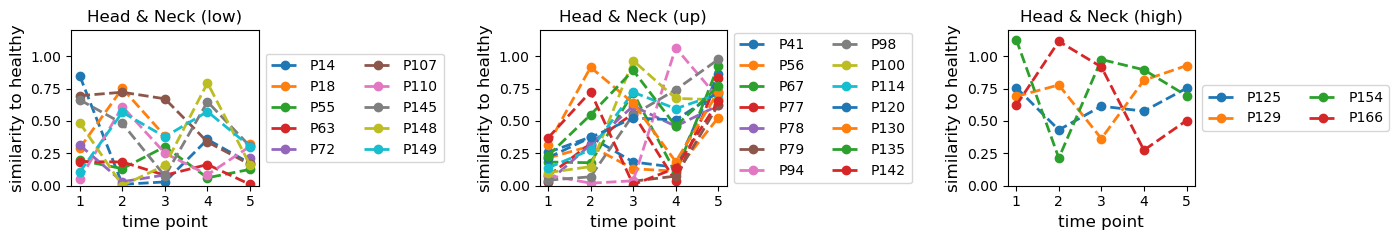

In [7]:
import matplotlib.pyplot as plt 

traj_groups = [pat_info[pat_info['trajectory'] == 'low'].index.values, 
               pat_info[pat_info['trajectory'] == 'up'].index.values, 
               pat_info[pat_info['trajectory'] == 'high'].index.values]
fig, axs = plt.subplots(1, 3, figsize=(14, 2.5))

for j, group in enumerate(traj_groups):
    pats = groups[groups['group'] == 'H&N cancer']['patient'].values
    pats = pats[np.isin(pats, group)]
    for p in pats:
        pres = res.loc[p]
        axs[j].plot(pres.index, pres.values, 'o--', lw=2, label=p)
    axs[j].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    axs[j].set_ylabel('similarity to healthy', size=12)
    axs[j].set_xlabel('time point', size=12)
    axs[j].set_xticks([1, 2, 3, 4, 5])
    axs[j].set_ylim(0, 1.2)

axs[0].set_title('Head & Neck (low)')
axs[1].set_title('Head & Neck (up)')
axs[2].set_title('Head & Neck (high)')
fig.tight_layout()
fig.subplots_adjust(wspace=1.5)

### Fig. 4a

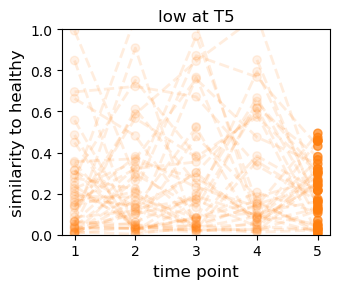

In [8]:
pats = pat_info[pat_info['trajectory'] == 'low'].index.values
colors = np.array([(1.0, 0.4980392156862745, 0.054901960784313725, 0.1)] * 4 + [(1.0, 0.4980392156862745, 0.054901960784313725, 0.7)])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
for p in pats:
    pres = res.loc[p]
    ax.plot(pres.index, pres.values, '--', lw=2, color='#ff7f0e22')
    ax.scatter(pres.index, pres.values, marker='o', color=colors)
ax.set_title('low at T5')
ax.set_ylabel('similarity to healthy', size=12)
ax.set_xlabel('time point', size=12)
ax.set_ylim(0, 1)
fig.tight_layout()

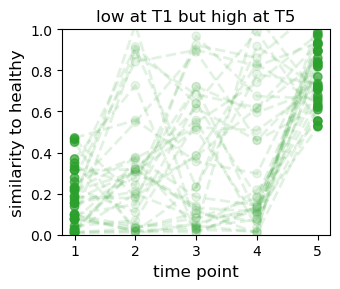

In [9]:
pats = pat_info[pat_info['trajectory'] == 'up'].index.values
colors = np.array([(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.7)] + 
                  [(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.1)] * 3 + 
                  [(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.7)])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
for p in pats:
    pres = res.loc[p]
    ax.plot(pres.index, pres.values, '--', lw=2, color='#2ca02c22')
    ax.scatter(pres.index, pres.values, marker='o', color=colors)
ax.set_title('low at T1 but high at T5')
ax.set_ylabel('similarity to healthy', size=12)
ax.set_xlabel('time point', size=12)
ax.set_ylim(0, 1)
fig.tight_layout()

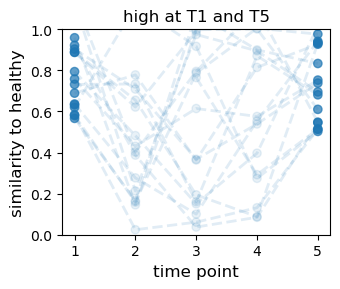

In [10]:
pats = pat_info[pat_info['trajectory'] == 'high'].index.values
colors = np.array([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.7)] + 
                  [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.1)] * 3 + 
                  [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.7)])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
for p in pats:
    pres = res.loc[p]
    ax.plot(pres.index, pres.values, '--', lw=2, color='#1f77b422')
    ax.scatter(pres.index, pres.values, marker='o', color=colors)
ax.set_title('high at T1 and T5')
ax.set_ylabel('similarity to healthy', size=12)
ax.set_xlabel('time point', size=12)
ax.set_ylim(0, 1)
fig.tight_layout()

### Fig. S4a

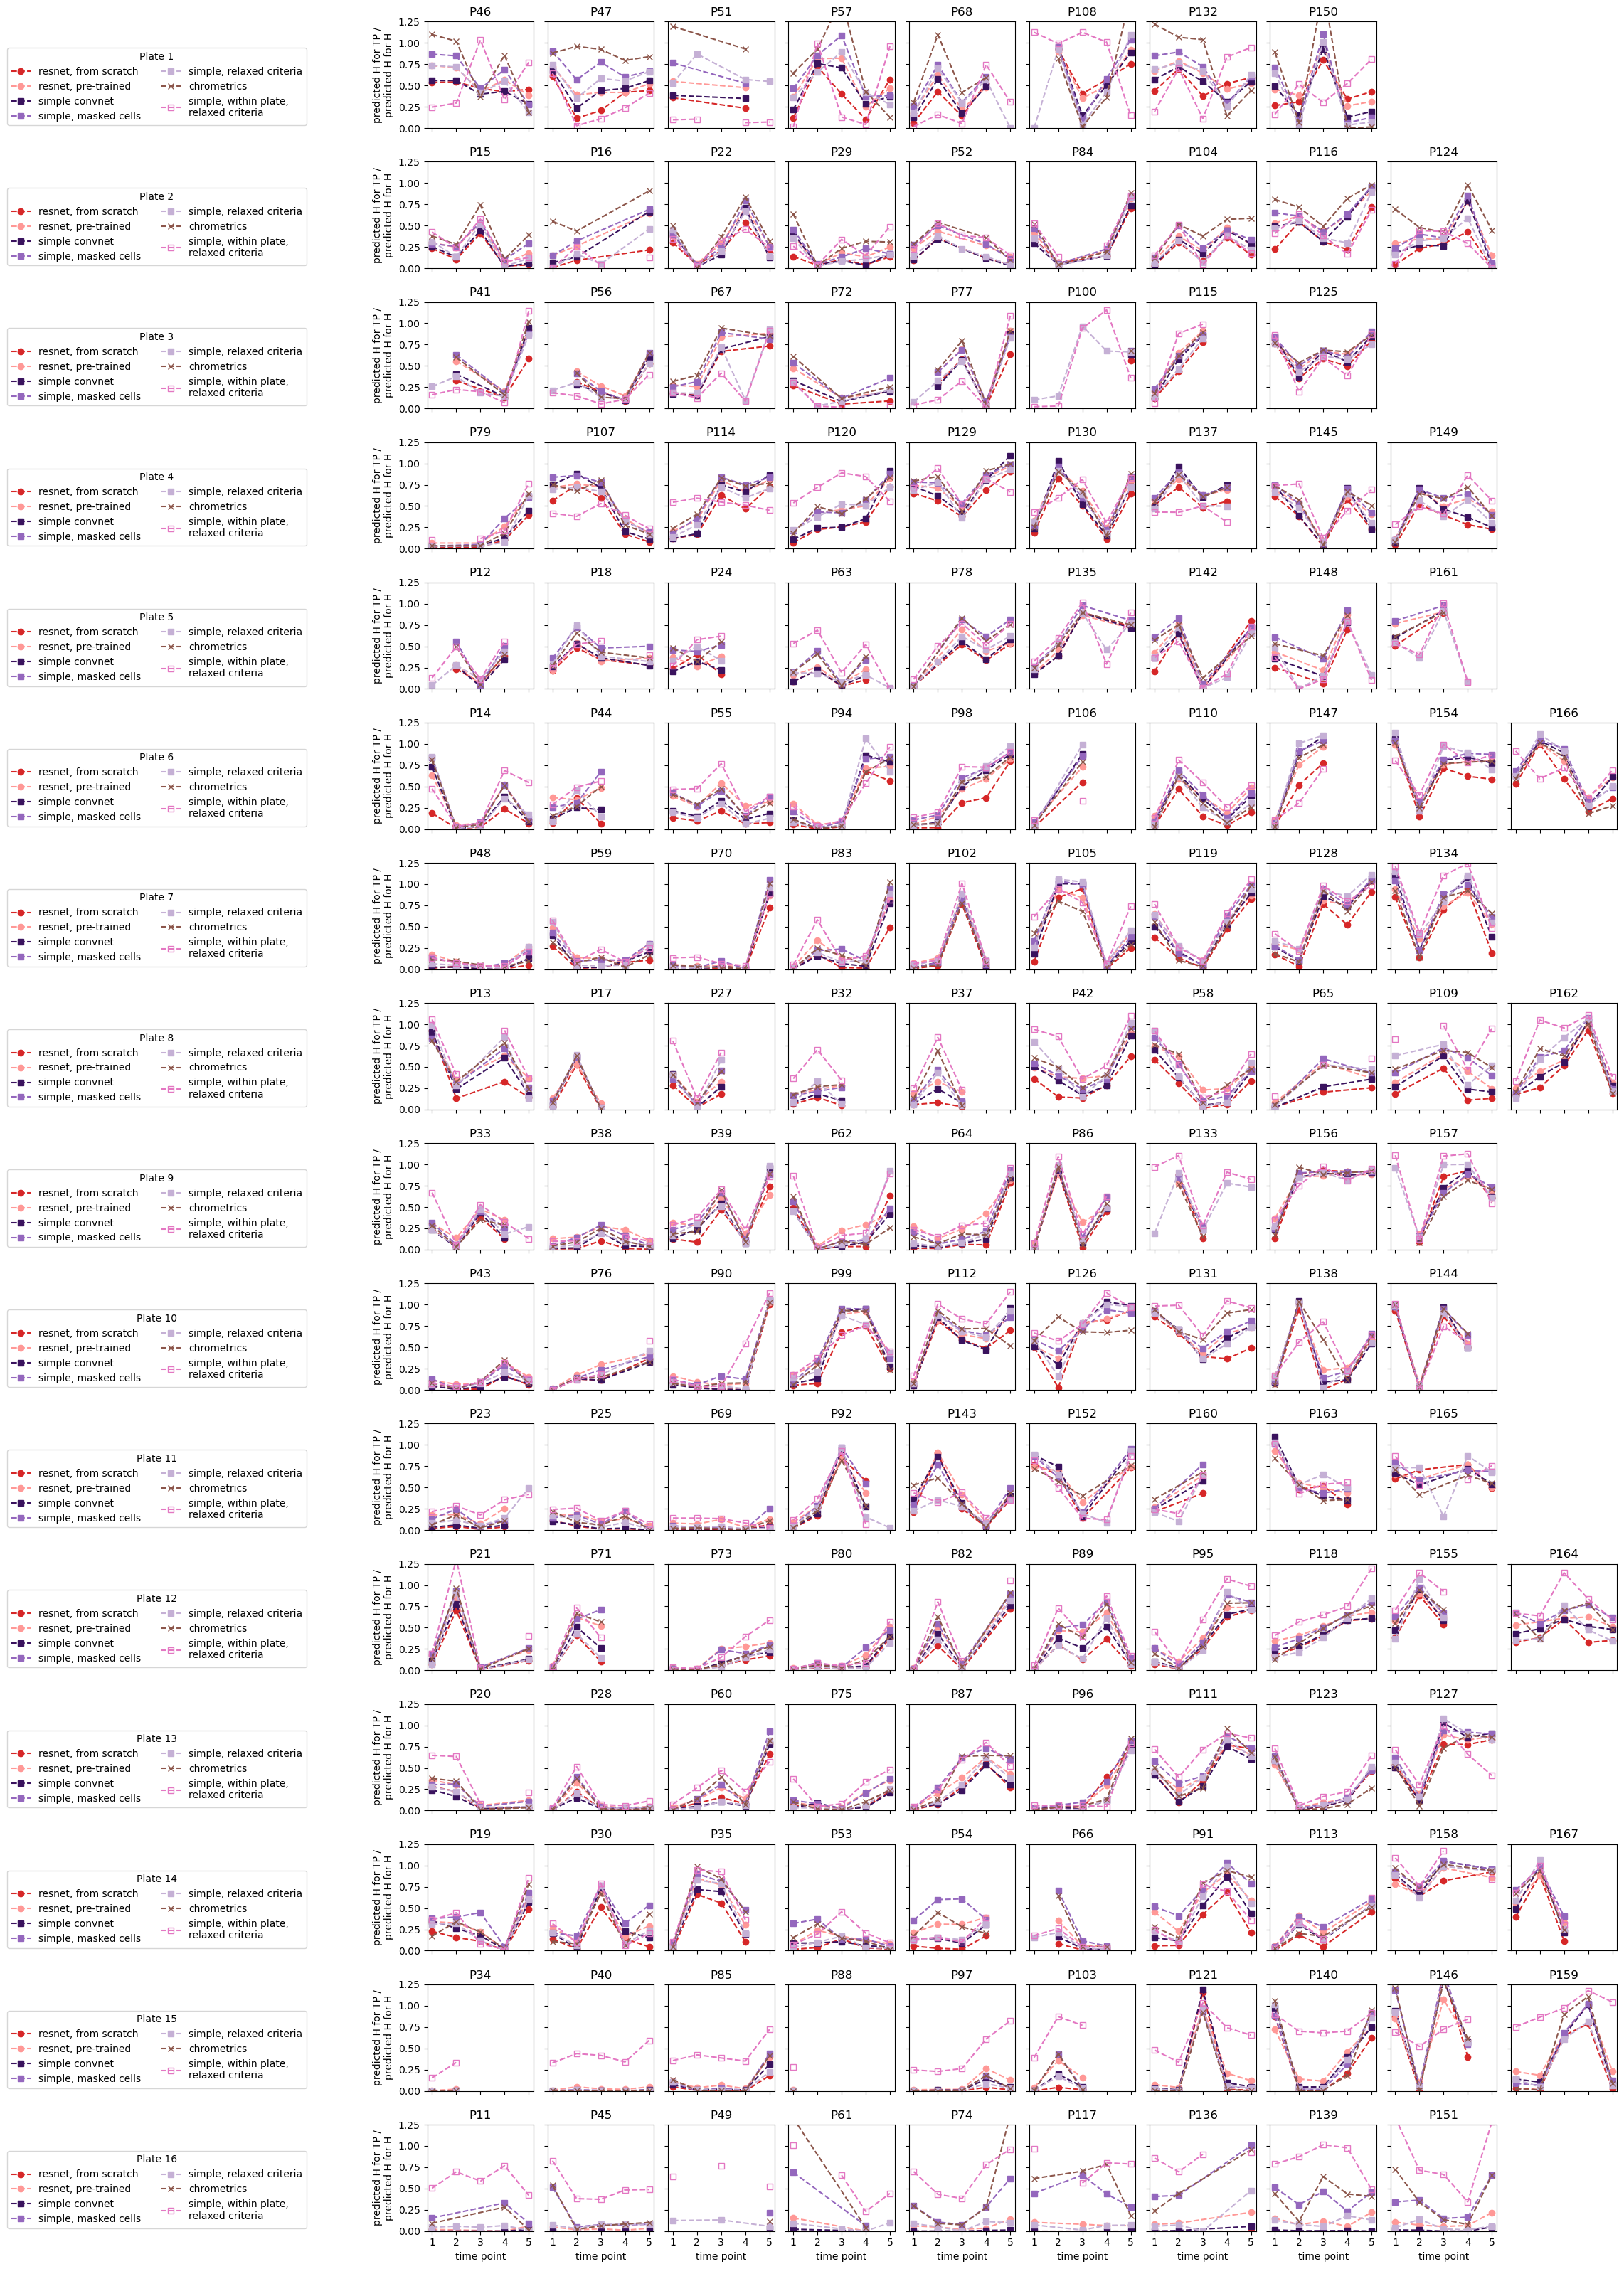

In [11]:
plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
fig, axxs = plt.subplots(len(plates), 10, figsize=(2*10+3, 2*len(plates)), sharey=True, sharex=True)

for plate, axs in zip(plates, axxs):

  res = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_scores.csv')
  res = res[res['plate'] == plate]
  patients = res[res['time'] == 1]['patient'].unique()
  pids = [int(p[1:]) for p in patients]
  patients = patients[np.argsort(pids)]
  if len(patients) > 10:  # make sure we're not skipping any while plotting due to lack of space
    print(plate, patients)

  res = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_resnet_from_scratch_scores.csv')
  res = res[res['plate'] == plate]
  for i, (p, ax) in enumerate(zip(patients, axs)):
    pres = res[res['patient'] == p]
    ax.plot(pres['time'], pres['score'], 'o--', label=f'resnet, from scratch', color='#d62728')
    ax.set_title(f'{p}')

  res = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_pretrained_resnet_scores.csv')
  res = res[res['plate'] == plate]
  for i, (p, ax) in enumerate(zip(patients, axs)):
    pres = res[res['patient'] == p]
    ax.plot(pres['time'], pres['score'], 'o--', label=f'resnet, pre-trained', color='#ff9896')
    ax.set_title(f'{p}')

  res = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_scores.csv')
  res = res[res['plate'] == plate]
  for i, (p, ax) in enumerate(zip(patients, axs)):
    pres = res[res['patient'] == p]
    ax.plot(pres['time'], pres['score'], 's--', label=f'simple convnet', color="#3a135e")
    ax.set_title(f'{p}')

  res = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_masked_scores.csv')
  res = res[res['plate'] == plate]
  for i, (p, ax) in enumerate(zip(patients, axs)):
    pres = res[res['patient'] == p]
    ax.plot(pres['time'], pres['score'], 's--', label=f'simple, masked cells', color='#9467bd')
    ax.set_title(f'{p}')

  res = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_scores.csv')
  res = res[res['plate'] == plate]
  for i, (p, ax) in enumerate(zip(patients, axs)):
    pres = res[res['patient'] == p]
    ax.plot(pres['time'], pres['score'], 's--', label=f'simple, relaxed criteria', color="#c5b0d5")
    ax.set_title(f'{p}')

  res = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_chrometrics_scores.csv')
  res = res[res['plate'] == plate]
  for i, (p, ax) in enumerate(zip(patients, axs)):
    pres = res[res['patient'] == p]
    ax.plot(pres['time'], pres['score'], 'x--', label=f'chrometrics', color='#8c564b')
    ax.set_title(f'{p}')

  res = pd.read_csv('results/within_plate_relaxed_mil_architecture_scores.csv')
  res = res[res['plate'] == plate]
  for i, (p, ax) in enumerate(zip(patients, axs)):
    pres = res[res['patient'] == p]
    ax.plot(pres['time'], pres['score'], 's--', label=f'simple, within plate,\nrelaxed criteria', 
            color='#e377c2', markerfacecolor='none')
    ax.set_title(f'{p}')
    
  for ax in axs:
    ax.set_ylim(0, 1.25)

  if plate == plates[-1]:
    for ax in axs:
      ax.set_xlabel('time point')
      ax.set_xticks([1, 2, 3, 4, 5])

  axs[0].legend(loc='upper left', bbox_to_anchor=(-4, 0.8), title=f'Plate {plate}', ncol=2)
  axs[0].set_ylabel('predicted H for TP /\npredicted H for H')
  for ax in axs[len(patients):]:
    ax.axis('off')

fig.tight_layout()
fig.show()

## Representations and images

In [70]:
data = PlateDataset([3, 4, 5, 6], load_masks=True, load_chrometrics=True, strict_discard=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.85s/it]


In [71]:
traj = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_trajectory_classes.csv', index_col='patient')

In [72]:
use_plates = np.array([3, 4, 5, 6])
use_groups = ['healthy', 'H&N cancer'] 

cdf = data.info[data.info['group'].isin(use_groups)].groupby(['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p1ts = traj[traj['trajectory'].isin(['up', 'low'])].index.values
p1ts = p1ts[np.isin(p1ts, p01s)]
p1ts

array(['P100', 'P107', 'P110', 'P114', 'P120', 'P130', 'P135', 'P14',
       'P142', 'P145', 'P148', 'P149', 'P18', 'P41', 'P55', 'P56', 'P63',
       'P67', 'P72', 'P77', 'P78', 'P79', 'P94', 'P98'], dtype=object)

In [73]:
p1ths = traj[traj['trajectory'].isin(['up', 'low', 'high'])].index.values
p1ths = p1ths[np.isin(p1ths, p01s)]
p01ths = np.concatenate([p1ths, [h for h in p01s if h[0] == 'H']])
p01ths

array(['P100', 'P107', 'P110', 'P114', 'P120', 'P125', 'P129', 'P130',
       'P135', 'P14', 'P142', 'P145', 'P148', 'P149', 'P154', 'P166',
       'P18', 'P41', 'P55', 'P56', 'P63', 'P67', 'P72', 'P77', 'P78',
       'P79', 'P94', 'P98', 'H06', 'H07', 'H10', 'H22', 'H23', 'H30',
       'H31', 'H37', 'H39', 'H40'], dtype=object)

### Fig. 4d

In [15]:
from torchvision.models import resnet18 as make_resnet18
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import DataLoader


def extract_resnet_patch_features(imgs, transform=None):
  model = make_resnet18(weights="DEFAULT").to('cuda:0')
  return_nodes = {
      'flatten': 'z',
  }
  device = 'cuda:0'
  feature_extractor = create_feature_extractor(model.eval().to(device), return_nodes=return_nodes)
  z = torch.zeros((len(imgs), 512))
  i = 0
  loader = DataLoader(imgs, batch_size=128, shuffle=False)
  # for batch in tqdm(loader):
  for img_batch in tqdm(loader):
    img_batch = img_batch.to(device).repeat(1, 3, 1, 1)
    if transform is not None:
      img_batch = transform(img_batch)
    with torch.no_grad():
      z[i:i+len(img_batch)] = feature_extractor(img_batch)['z'].cpu()
    i += len(img_batch)
  return z


res_zs = extract_resnet_patch_features(data.imgs)
res_zs.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3607/3607 [00:19<00:00, 184.34it/s]


torch.Size([461688, 512])

In [13]:
np.random.seed(1234)

vis_info = []
vis_idx = []
healthy = [h for h in p01ths if h[0] == 'H']
for h in healthy:
    n = 100
    vis_idx.append(np.random.choice(data.info[data.info['plate'].isin(use_plates) & 
                                              data.info['time'].isin([0, 1]) & 
                                              data.info['patient'].isin([h])].index, size=n))
    vis_info.extend([(h, 'healthy')] * n)

tlut = traj.loc[p1ths].reset_index().groupby('trajectory')['patient'].unique()
for p in tlut['high']:
    n = int(100 *  len(healthy) / len(tlut['high']))
    vis_idx.append(np.random.choice(data.info[data.info['plate'].isin(use_plates) & 
                                              data.info['time'].isin([0, 1]) & 
                                              data.info['patient'].isin([p])].index, size=n))
    vis_info.extend([(p, 'high')] * n)

for p in tlut['low']:
    n = int(100 *  len(healthy) / len(tlut['low']))
    vis_idx.append(np.random.choice(data.info[data.info['plate'].isin(use_plates) & 
                                              data.info['time'].isin([0, 1]) & 
                                              data.info['patient'].isin([p])].index, size=n))
    vis_info.extend([(p, 'low')] * n)

for p in tlut['up']:
    n = int(100 *  len(healthy) / len(tlut['up']))
    vis_idx.append(np.random.choice(data.info[data.info['plate'].isin(use_plates) & 
                                              data.info['time'].isin([0, 1]) & 
                                              data.info['patient'].isin([p])].index, size=n))
    vis_info.extend([(p, 'up')] * n)

vis_info = pd.DataFrame(vis_info, columns=['patient', 'group'])
vis_idx = np.concatenate(vis_idx)
vis_info.groupby('group')['patient'].count()

group
healthy    1000
high       1000
low        1000
up          994
Name: patient, dtype: int64

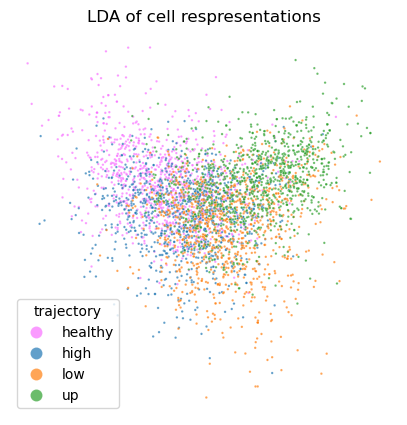

In [16]:
# from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

vis_info['trajectory'] = vis_info['group']
vis_info[['lda_x', 'lda_y']] = LDA(n_components=2).fit(res_zs[vis_idx], vis_info['trajectory']).transform(res_zs[vis_idx])


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=vis_info, x='lda_x', y='lda_y', hue='trajectory', s=3, ax=ax, alpha=0.7,
                 palette={'up' : '#2ca02c', 'low' : '#ff7f0e', 'high' : '#1f77b4', 'healthy' :  '#f970ff'})
ax.set_title('LDA of cell respresentations')
sns.move_legend(ax, 'best', markerscale=5)
ax.axis('off');

### Fig. S4b

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


def get_vis_idx(t, cdf, use_plates, traj, show_classes=['up', 'low', 'high']):
    p01s = cdf[(cdf['time'] == t) | (cdf['time'] == 0)]['patient'].unique()
    p1ts = traj[traj['trajectory'].isin(show_classes)].index.values
    p1ts = p1ts[np.isin(p1ts, p01s)]

    np.random.seed(1234)

    vis_info = []
    vis_idx = []
    healthy = [h for h in p01s if h[0] == 'H']
    for h in healthy:
        n = 100
        vis_idx.append(np.random.choice(data.info[data.info['plate'].isin(use_plates) & 
                                                data.info['time'].isin([0, t]) & 
                                                data.info['patient'].isin([h])].index, size=n))
        vis_info.extend([(h, 'healthy')] * n)

    tlut = traj.loc[p1ts].reset_index().groupby('trajectory')['patient'].unique()
    for tj in tlut.index:
        for p in tlut[tj]:
            n = int(100 *  len(healthy) / len(tlut[tj]))
            vis_idx.append(np.random.choice(data.info[data.info['plate'].isin(use_plates) & 
                                                    data.info['time'].isin([0, t]) & 
                                                    data.info['patient'].isin([p])].index, size=n))
            vis_info.extend([(p, tj)] * n)

    vis_info = pd.DataFrame(vis_info, columns=['patient', 'group'])
    vis_idx = np.concatenate(vis_idx)
    return vis_idx, vis_info


def make_lda_plots(use_groups, use_plates, traj, fig_scale=5, legend=True, show_classes=['up', 'low', 'high']):
    cdf = data.info[data.info['group'].isin(use_groups) & data.info['plate'].isin(use_plates)].groupby(['patient', 'time'])['cell'].count().reset_index()
    cdf = cdf[(cdf['cell'] > 100)]

    fig, axs = plt.subplots(1, 5, figsize=(5*fig_scale, fig_scale))
    for t, ax in zip([1, 2, 3, 4, 5], axs):
        vis_idx, vis_info = get_vis_idx(t, cdf, use_plates, traj, show_classes)
        print(f'cell counts used for time {t}', vis_info.groupby('group')['patient'].count())

        vis_info['trajectory'] = vis_info['group']
        vis_info[['lda_x', 'lda_y']] = LDA(n_components=2).fit(res_zs[vis_idx], vis_info['trajectory']).transform(res_zs[vis_idx])

        sns.scatterplot(data=vis_info, x='lda_x', y='lda_y', hue='trajectory', s=3, ax=ax, alpha=0.7, legend=legend,
                        palette={'up' : '#2ca02c', 'low' : '#ff7f0e', 'high' : '#1f77b4', 'healthy' :  '#f970ff'})
        ax.set_title(f'LDA of cell respresentations\nfrom time point {t}')
        if legend:
            sns.move_legend(ax, 'best', markerscale=5)
        ax.axis('off');
    fig.tight_layout()
    fig.show()


def make_lda_plots_color_low_pats(use_groups, use_plates, traj, fig_scale=5, show_classes=['up', 'low', 'high'], legend=True):
    cdf = data.info[data.info['group'].isin(use_groups) & data.info['plate'].isin(use_plates)].groupby(['patient', 'time'])['cell'].count().reset_index()
    cdf = cdf[(cdf['cell'] > 100)]

    fig, axs = plt.subplots(1, 5, figsize=(5*fig_scale, fig_scale))
    for t, ax in zip([1, 2, 3, 4, 5], axs):
        vis_idx, vis_info = get_vis_idx(t, cdf, use_plates, traj, show_classes)
        print(f'cell counts used for time {t}', vis_info.groupby('group')['patient'].count())

        vis_info['trajectory'] = vis_info['group']
        vis_info[['lda_x', 'lda_y']] = LDA(n_components=2).fit(res_zs[vis_idx], vis_info['trajectory']).transform(res_zs[vis_idx])

        sns.scatterplot(data=vis_info[vis_info['group'] != 'low'], x='lda_x', y='lda_y', color='black', 
                        label='other', alpha=0.3, s=3, ax=ax, legend=legend)

        if t == 1:
            patients = vis_info[vis_info['group'] == 'low']['patient'].unique()
            pids = [int(p[1:]) for p in patients]
            patients = patients[np.argsort(pids)]
        sns.scatterplot(data=vis_info[vis_info['group'] == 'low'], x='lda_x', y='lda_y', hue='patient', s=5, ax=ax, 
                        hue_order=patients, legend=legend)

        ax.set_title(f'LDA of cell respresentations\nfrom time point {t}')
        if legend:
          sns.move_legend(ax, 'upper left', markerscale=5, bbox_to_anchor=(-0.1, 0), ncol=3, title='low patient') 
        ax.axis('off');
    fig.tight_layout()
    fig.show()

cell counts used for time 1 group
healthy    1000
high       1000
low        1000
up          994
Name: patient, dtype: int64
cell counts used for time 2 group
healthy    1000
high       1000
low        1000
up          988
Name: patient, dtype: int64
cell counts used for time 3 group
healthy    1000
high       1000
low        1000
up          994
Name: patient, dtype: int64
cell counts used for time 4 group
healthy    1000
high       1000
low        1000
up          994
Name: patient, dtype: int64
cell counts used for time 5 group
healthy    1000
high       1000
low        1000
up          994
Name: patient, dtype: int64


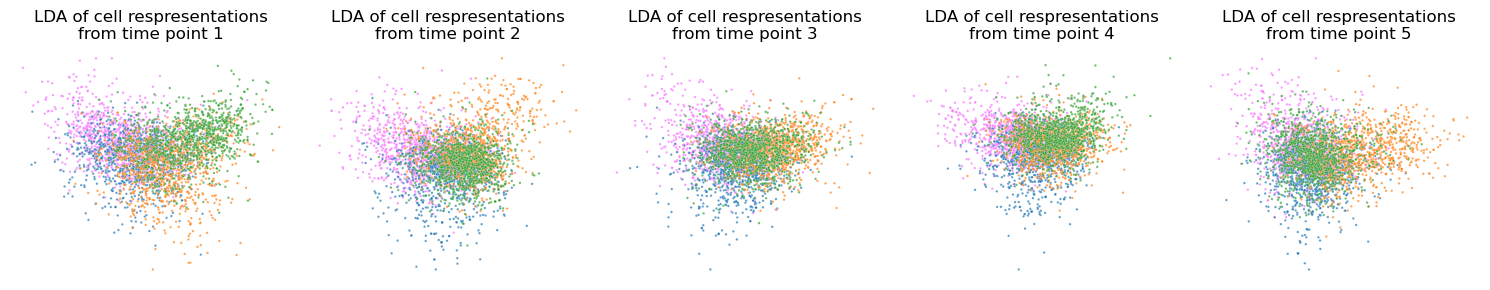

In [ ]:
make_lda_plots(use_groups, use_plates, traj, fig_scale=3, legend=False)

cell counts used for time 1 group
healthy    1000
high       1000
low        1000
up          994
Name: patient, dtype: int64
cell counts used for time 2 group
healthy    1000
high       1000
low        1000
up          988
Name: patient, dtype: int64
cell counts used for time 3 group
healthy    1000
high       1000
low        1000
up          994
Name: patient, dtype: int64
cell counts used for time 4 group
healthy    1000
high       1000
low        1000
up          994
Name: patient, dtype: int64
cell counts used for time 5 group
healthy    1000
high       1000
low        1000
up          994
Name: patient, dtype: int64


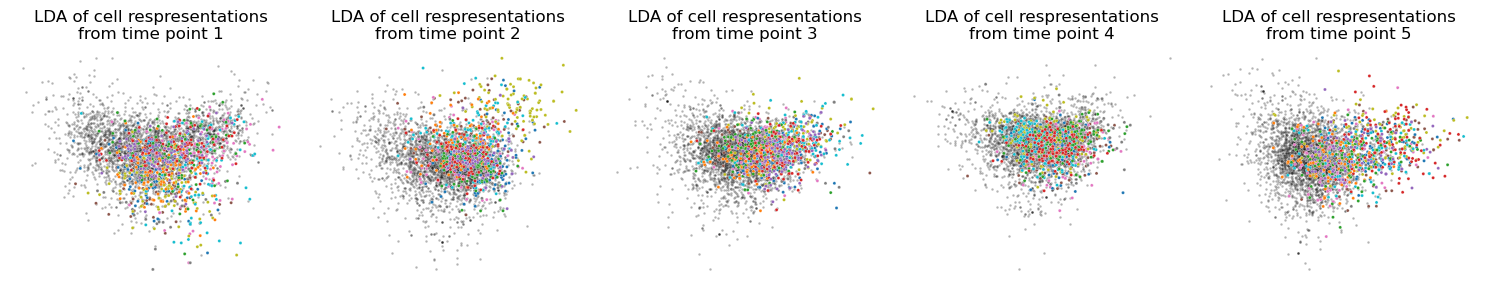

In [ ]:
make_lda_plots_color_low_pats(use_groups, use_plates, traj, fig_scale=3, legend=False)

### Fig. 4g

In [74]:
healthy = data.info[data.info['group'] == 'healthy']['patient'].unique()
for h in healthy:
    traj.loc[h, 'trajectory'] = None

In [75]:
groups = pd.read_csv('meta/patient_diagnosis_groups.csv')
groups = groups.set_index('patient')
groups

group
patient                          
P11      Sarcoma-Rhabdomyosarcoma
P12                    H&N cancer
P13                      Lymphoma
P14                    H&N cancer
P15                    CNS-Glioma
...                           ...
H46                       healthy
H47                       healthy
H48                       healthy
H49                       healthy
H50                       healthy

[207 rows x 1 columns]

In [80]:
def eval_model(classifier_name, loader, branches=5, classes=1):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    masks = []
    for i, (bag, mask, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn
    return df, bag_zs, bags, masks


def eval_model_with_chrometric(classifier_name, loader, branches=5, classes=1):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    masks = []
    chrometrics = []
    for i, (bag, mask, lab, pat, group, cs) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())
        chrometrics.append(cs)

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn
    chrometrics = pd.concat(chrometrics, ignore_index=True)
    return df, bag_zs, bags, masks, chrometrics


def test_up_vs_low_bagloader(bag_size=50, reps=11, use_patients=p1ts, use_times=[1], use_plates=use_plates, device=device, 
                             transform=T.CenterCrop(28), use_groups=use_groups, return_chrometric=False):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times) & data.info['group'].isin(use_groups)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  use_masks = transform(data.masks[use_idx].to(device))
  if return_chrometric:
    use_chrometric = data.chrometrics.iloc[use_idx].reset_index()
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any() or not groups.loc[pat, 'group'] in use_groups:
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    for _ in range(reps):
      idx = torch_random_choice(pat_idx, size=bag_size)
      xs = use_data[idx]
      t = traj.loc[pat, 'trajectory']
      label = 1 if t == 'up' else 0
      if not return_chrometric:
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, t
      else: 
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, t, use_chrometric.loc[idx.cpu().numpy()]

In [81]:
name = '3_6_traj'
group = 'H&N cancer'

test_loader = test_up_vs_low_bagloader(use_groups=[group], use_patients=p1ts, return_chrometric=True)
res_df, zs, imgs, masks, chrometrics = eval_model_with_chrometric(name, test_loader) 
res_df

lab  pred    i   pat group  attention 0  attention 1  attention 2  \
0        1   1.0    0  P100    up     0.016105     0.011572     0.025414   
1        1   1.0    0  P100    up     0.014869     0.011113     0.020541   
2        1   1.0    0  P100    up     0.015447     0.015402     0.038947   
3        1   1.0    0  P100    up     0.042048     0.028205     0.011721   
4        1   1.0    0  P100    up     0.011792     0.017830     0.030480   
...    ...   ...  ...   ...   ...          ...          ...          ...   
13195    1   1.0  263   P98    up     0.001878     0.002416     0.000661   
13196    1   1.0  263   P98    up     0.018955     0.019726     0.042034   
13197    1   1.0  263   P98    up     0.010112     0.004636     0.004638   
13198    1   1.0  263   P98    up     0.000803     0.003154     0.000671   
13199    1   1.0  263   P98    up     0.012917     0.014305     0.019553   

       attention 3  attention 4  raw attention 0  raw attention 1  \
0         0.009037     0.020959         2.286804        -0.205112   
1         0.009693     0.018901         2.206977        -0.245575   
2         0.006283     0.030941         2.245100         0.080753   
3         0.007440     0.019023         3.246511         0.685768   
4         0.006200     0.030102         1.975103         0.227156   
...            ...          ...              ...              ...   
13195     0.055654     0.001910         0.375676        -1.705533   
13196     0.004782     0.037440         2.687354         0.394195   
13197     0.034500     0.007031         2.059053        -1.053768   
13198     0.038173     0.001951        -0.474696        -1.439041   
13199     0.006981     0.026843         2.303800         0.072878   

       raw attention 2  raw attention 3  raw attention 4  
0             2.360424         0.266198        -0.351633  
1             2.147537         0.336274        -0.454995  
2             2.787338        -0.097379         0.037867  
3             1.586497         0.071659        -0.448553  
4             2.542209        -0.110602         0.010378  
...                ...              ...              ...  
13195        -0.441398         1.819970        -2.537554  
13196         3.710623        -0.634314         0.437854  
13197         1.506422         1.341767        -1.234568  
13198        -0.427170         1.442962        -2.516472  
13199         2.945256        -0.256007         0.105126  

[13200 rows x 15 columns]

In [82]:
(res_df['pred'] == res_df['lab']).mean()

0.9053030303030303

In [83]:
np.random.seed(1234)
# vis_idx = np.random.choice(np.arange(len(res_df)), replace=False, size=5000)
vis_idx = np.arange(len(res_df))
res_df[['umap_x', 'umap_y']] = np.nan
res_df.loc[vis_idx, ['umap_x', 'umap_y']] = umap.UMAP(random_state=123).fit_transform(np.array(zs)[vis_idx])

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


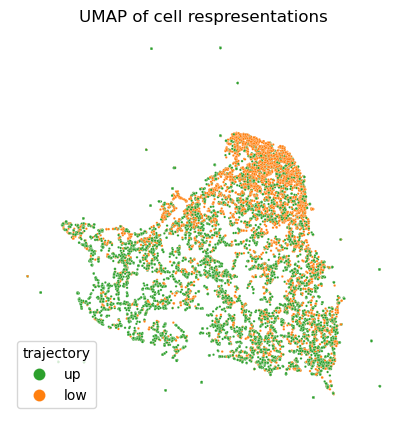

In [84]:
res_df.loc[res_df['lab'] == 1, 'trajectory'] = 'up'
res_df.loc[res_df['lab'] == 0, 'trajectory'] = 'low'

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue='trajectory', s=3, ax=ax, palette={'up' : '#2ca02c', 'low' : '#ff7f0e'})
ax.set_title('UMAP of cell respresentations')
sns.move_legend(ax, 'lower left', markerscale=5)
ax.axis('off');

In [85]:
res_df['total attention'] = res_df['attention 0'] + res_df['attention 1'] + res_df['attention 2'] + res_df['attention 3']  +res_df['attention 4']
correct_low_bags = res_df[(res_df['lab'] == res_df['pred']) & (res_df['trajectory'] == 'low')]['i'].unique()
correct_up_bags = res_df[(res_df['lab'] == res_df['pred']) & (res_df['trajectory'] == 'up')]['i'].unique()

In [86]:
img_array = np.array(imgs).reshape((264, 50, 1, 28, 28))
mask_array = np.array(masks).reshape((264, 50, 1, 28, 28))
img_array.shape

(264, 50, 1, 28, 28)

### Fig. 4i

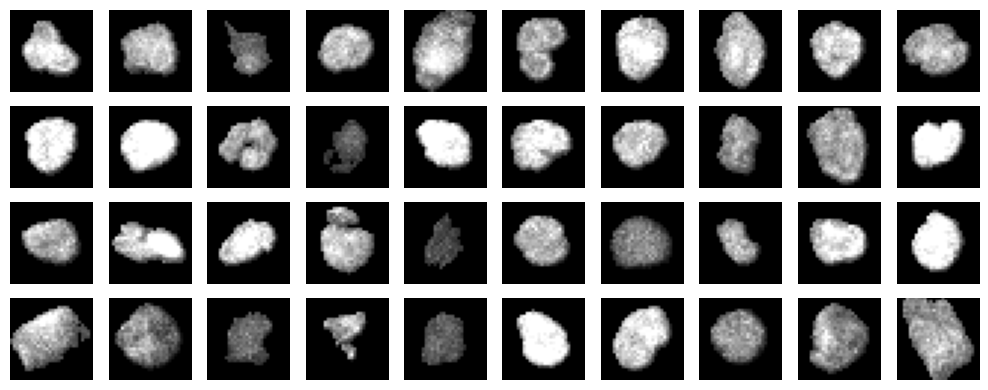

In [87]:
top_up_imgs = []
top_up_masks = []
for i in correct_up_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_up_imgs.extend(img_array[i, idx])
    top_up_masks.extend(mask_array[i, idx])
top_up_imgs = np.array(top_up_imgs)
top_up_masks = np.array(top_up_masks)

np.random.seed(25323)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_up_imgs)), replace=False, size=40)
for im, m, ax in zip(top_up_imgs[show_idx], top_up_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

### Fig. 4h

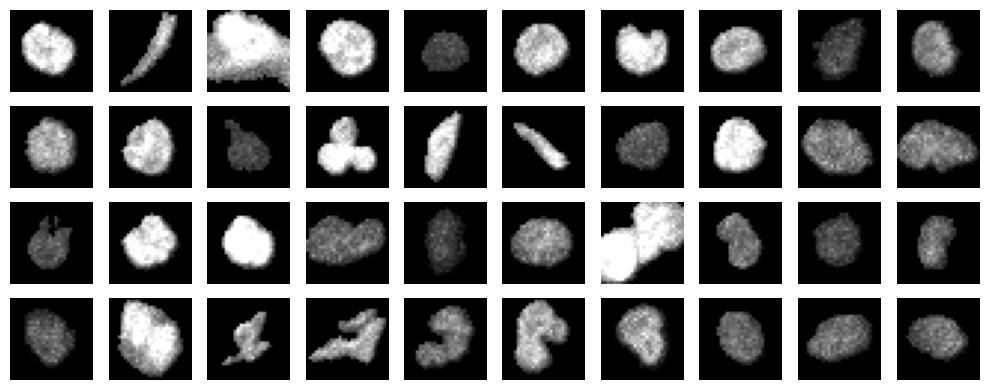

In [88]:
top_low_imgs = []
top_low_masks = []
for i in correct_low_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_low_imgs.extend(img_array[i, idx])
    top_low_masks.extend(mask_array[i, idx])
top_low_imgs = np.array(top_low_imgs)
top_low_masks = np.array(top_low_masks)

np.random.seed(51313)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_low_imgs)), replace=False, size=40)
for im, m, ax in zip(top_low_imgs[show_idx], top_low_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

## Compare chrometric features for high vs. low attention

In [101]:
top_up_idx = []
for i in correct_up_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_up_idx.append(i * 50 + idx)
top_up_idx = np.concatenate(top_up_idx)

top_low_idx = []
for i in correct_low_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_low_idx.append(i * 50 + idx)
top_low_idx = np.concatenate(top_low_idx)

In [102]:
bot_up_idx = []
for i in correct_up_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[:3]  # take first 3
    bot_up_idx.append(i * 50 + idx)
bot_up_idx = np.concatenate(bot_up_idx)

bot_low_idx = []
for i in correct_low_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[:3]  # take first 3
    bot_low_idx.append(i * 50 + idx)
bot_low_idx = np.concatenate(bot_low_idx)

In [103]:
print(len(bot_low_idx), len(bot_up_idx), len(top_up_idx), len(top_low_idx))
m = min(len(bot_low_idx), len(bot_up_idx), len(top_up_idx), len(top_low_idx))

288 429 429 288


In [104]:
cnt = []
for col in chrometrics.columns[1:]:
    cnt.append((chrometrics.loc[res_df['lab'] == 0, col].isna().sum(), len(chrometrics.loc[res_df['lab'] == 0, col]), 
                chrometrics.loc[res_df['lab'] == 1, col].isna().sum(), len(chrometrics.loc[res_df['lab'] == 1, col].isna())))
cnt = pd.DataFrame(cnt, index=chrometrics.columns[1:], columns=['lab 0 nan', 'lab 0 cnt', 'lab 1 nan', 'lab 1 cnt'])
cnt
nan_cnt = cnt[(cnt['lab 0 nan'] != 0) | (cnt['lab 1 nan'] != 0)]
bad_cols = nan_cnt.index
nan_cnt

lab 0 nan  lab 0 cnt  lab 1 nan  lab 1 cnt
max_neg_curv                           110       5500        168       7700
avg_neg_curv                           110       5500        168       7700
med_neg_curv                           110       5500        168       7700
std_neg_curv                           110       5500        168       7700
sum_neg_curv                           110       5500        168       7700
len_neg_curv                           110       5500        168       7700
prominance_prominant_pos_curv          376       5500        742       7700
width_prominant_pos_curv               376       5500        742       7700
prominant_pos_curv                     376       5500        742       7700
prominance_prominant_neg_curv         2308       5500       3906       7700
width_prominant_neg_curv              2308       5500       3906       7700
prominant_neg_curv                    2308       5500       3906       7700
frac_peri_w_neg_curvature              110       5500        168       7700
weighted_moments_normalized-0-0       5500       5500       7700       7700
weighted_moments_normalized-0-1       5500       5500       7700       7700
weighted_moments_normalized-1-0       5500       5500       7700       7700
moments_normalized-0-0                5500       5500       7700       7700
moments_normalized-0-1                5500       5500       7700       7700
moments_normalized-1-0                5500       5500       7700       7700

In [105]:
bot_cnt = []
for col in chrometrics.columns[1:]:
    bot_cnt.append((chrometrics.loc[bot_low_idx, col].isna().sum(), len(chrometrics.loc[bot_low_idx, col]), 
                    chrometrics.loc[bot_up_idx, col].isna().sum(), len(chrometrics.loc[bot_up_idx, col])))
bot_cnt = pd.DataFrame(bot_cnt, index=chrometrics.columns[1:], columns=['lab 0 nan', 'lab 0 cnt', 'lab 1 nan', 'lab 1 cnt'])

bot_ps_h = []
bot_ps_c = []
np.random.seed(5213)
for col in chrometrics.columns[1:]:
    bot_ps_h.append(stats.kstest(chrometrics.loc[np.random.choice(top_up_idx, size=m, replace=False), col].values, 
                                 chrometrics.loc[np.random.choice(bot_up_idx, size=m, replace=False), col].values).pvalue)
    bot_ps_c.append(stats.kstest(chrometrics.loc[np.random.choice(top_low_idx, size=m, replace=False), col].values, 
                                 chrometrics.loc[np.random.choice(bot_low_idx, size=m, replace=False), col].values).pvalue)
bot_ps_h = np.array(bot_ps_h)
bot_ps_c = np.array(bot_ps_c)
bot_cnt['p-val (up)'] = bot_ps_h
bot_cnt['p-val (low)'] = bot_ps_c
bot_cnt = bot_cnt[~(bot_cnt.index.isin(bad_cols))].sort_values('p-val (up)')
bot_cnt

lab 0 nan  lab 0 cnt  lab 1 nan  lab 1 cnt  \
weighted_moments-0-0            0        288          0        429   
int_d75                         0        288          0        429   
weighted_moments_hu-0           0        288          0        429   
hc_content_dna_content          0        288          0        429   
avg_posi_curv                   0        288          0        429   
...                           ...        ...        ...        ...   
contrast_100                    0        288          0        429   
asm_100                         0        288          0        429   
dissimilarity_100               0        288          0        429   
energy_100                      0        288          0        429   
homogeneity_100                 0        288          0        429   

                          p-val (up)   p-val (low)  
weighted_moments-0-0    3.131215e-41  5.240203e-05  
int_d75                 1.273001e-39  1.444181e-14  
weighted_moments_hu-0   4.291558e-39  8.522775e-16  
hc_content_dna_content  1.432670e-38  1.475950e-25  
avg_posi_curv           4.736366e-38  7.691069e-07  
...                              ...           ...  
contrast_100            1.000000e+00  1.000000e+00  
asm_100                 1.000000e+00  1.000000e+00  
dissimilarity_100       1.000000e+00  1.000000e+00  
energy_100              1.000000e+00  1.000000e+00  
homogeneity_100         1.000000e+00  1.000000e+00  

[182 rows x 6 columns]

### Fig. S4h

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


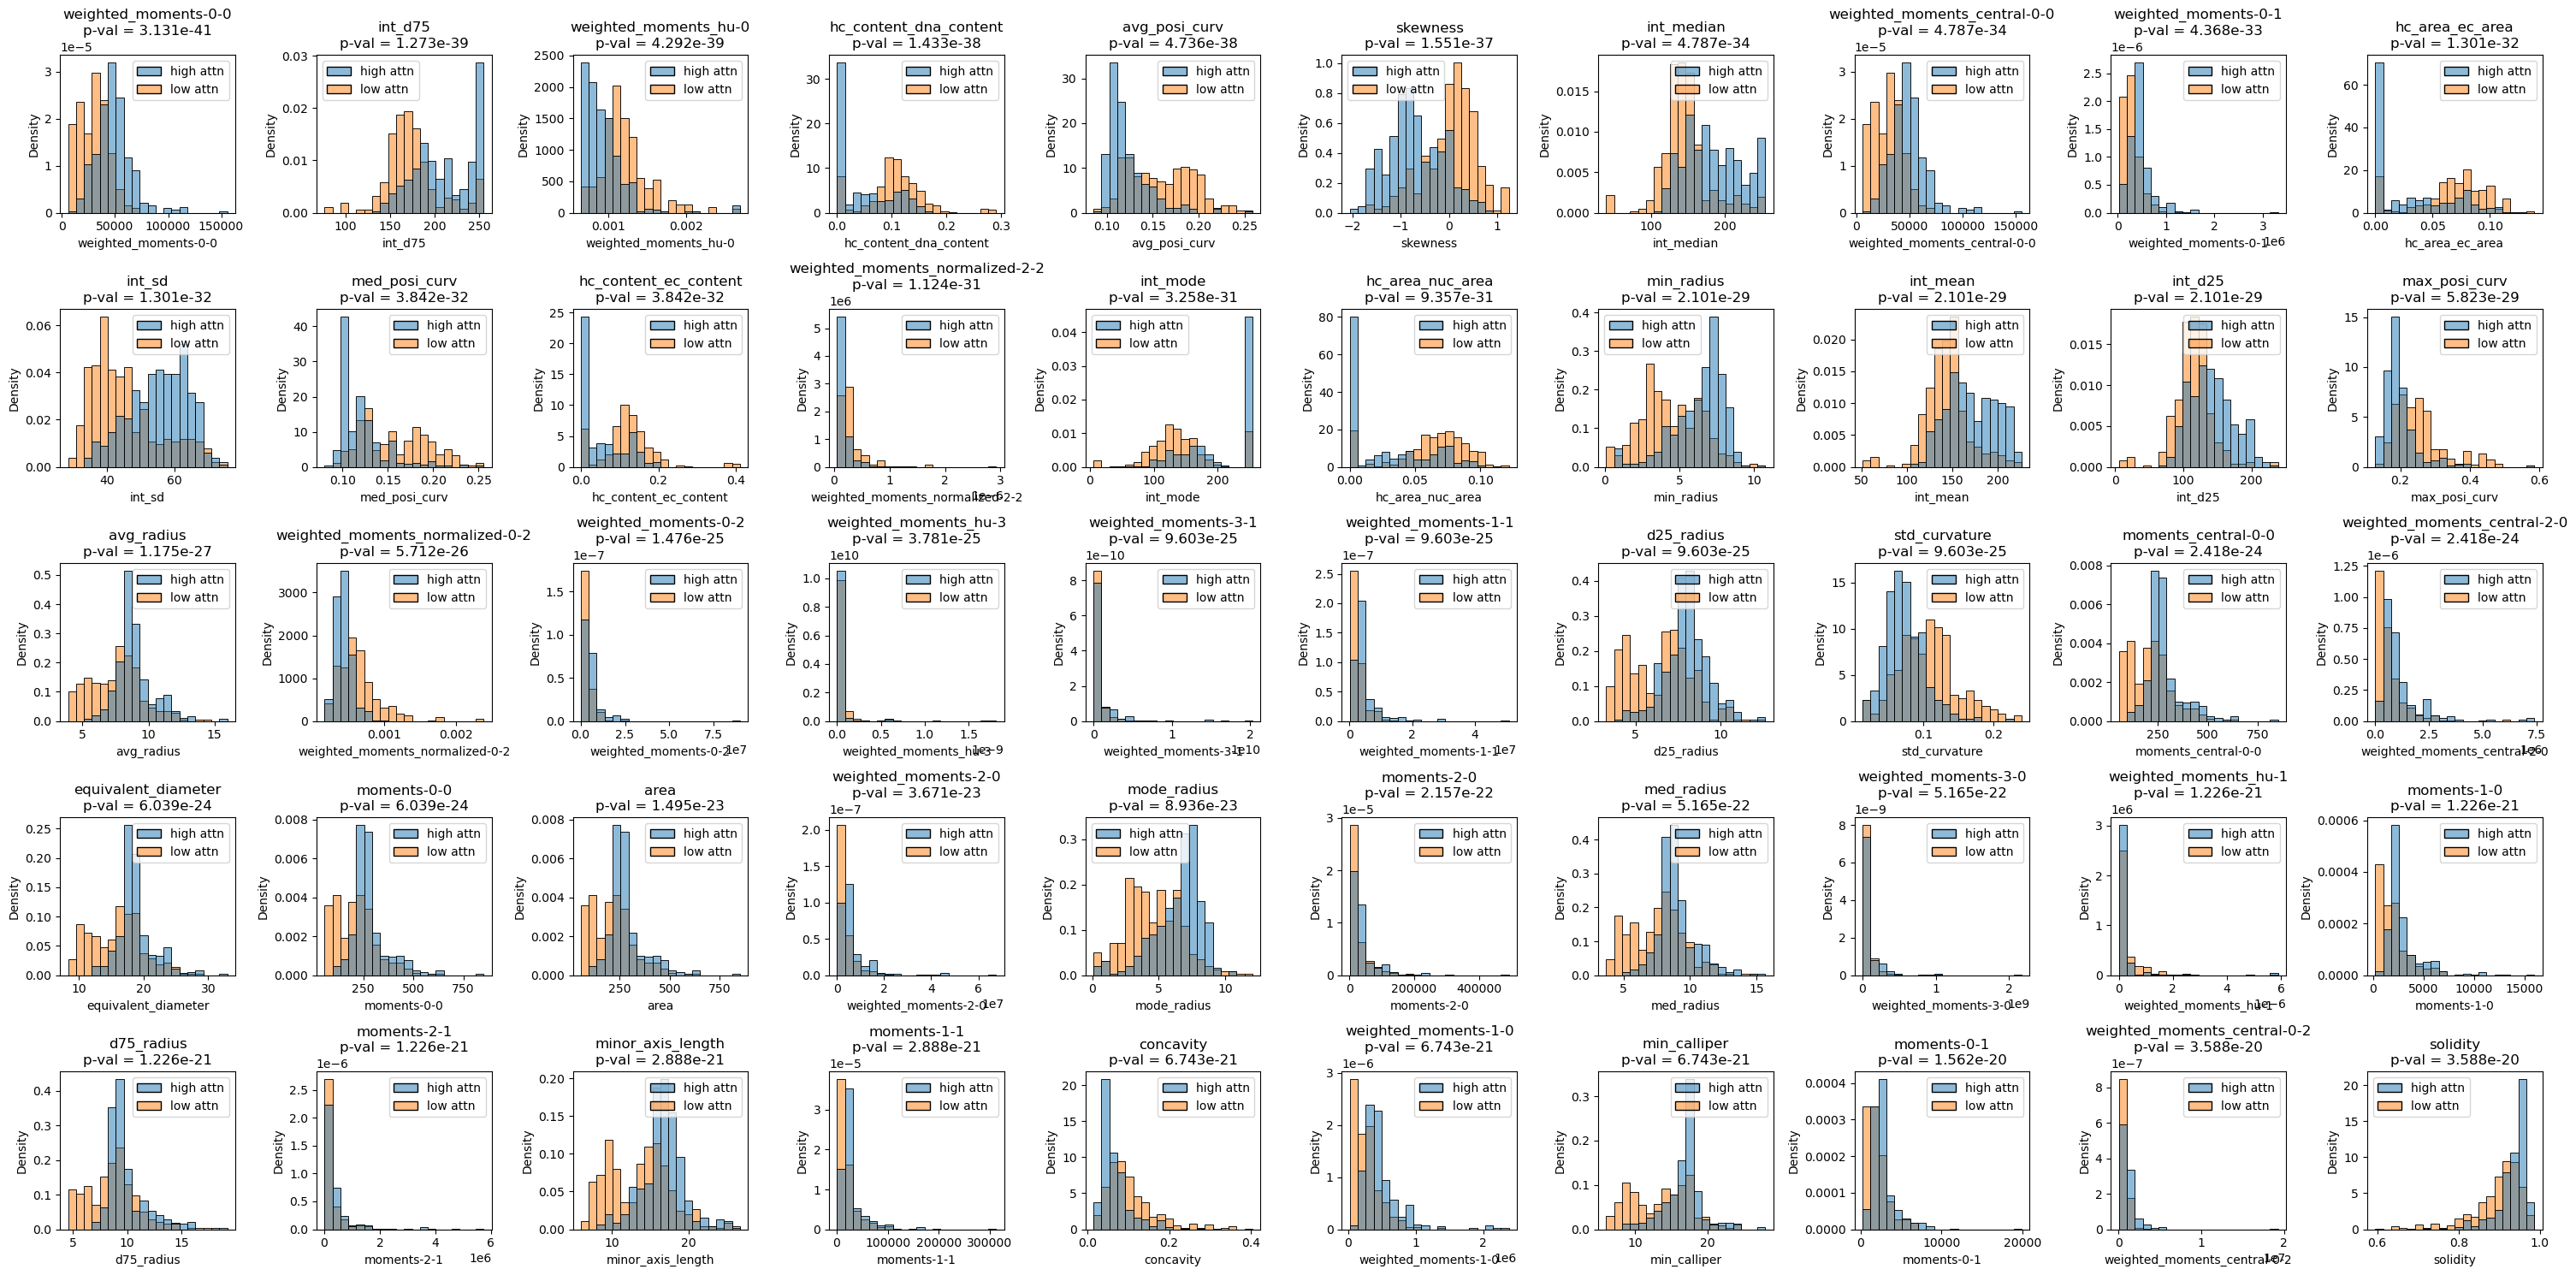

In [106]:
fig, axs = plt.subplots(5, 10, figsize=(30, 15))
for ax, col in zip(axs.flatten(), bot_cnt.sort_values('p-val (up)').index):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_up_idx, bot_up_idx))], x=col, 
                 hue=['high attn'] * len(top_up_idx) + ['low attn'] * len(bot_up_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (up)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

### Fig S4g

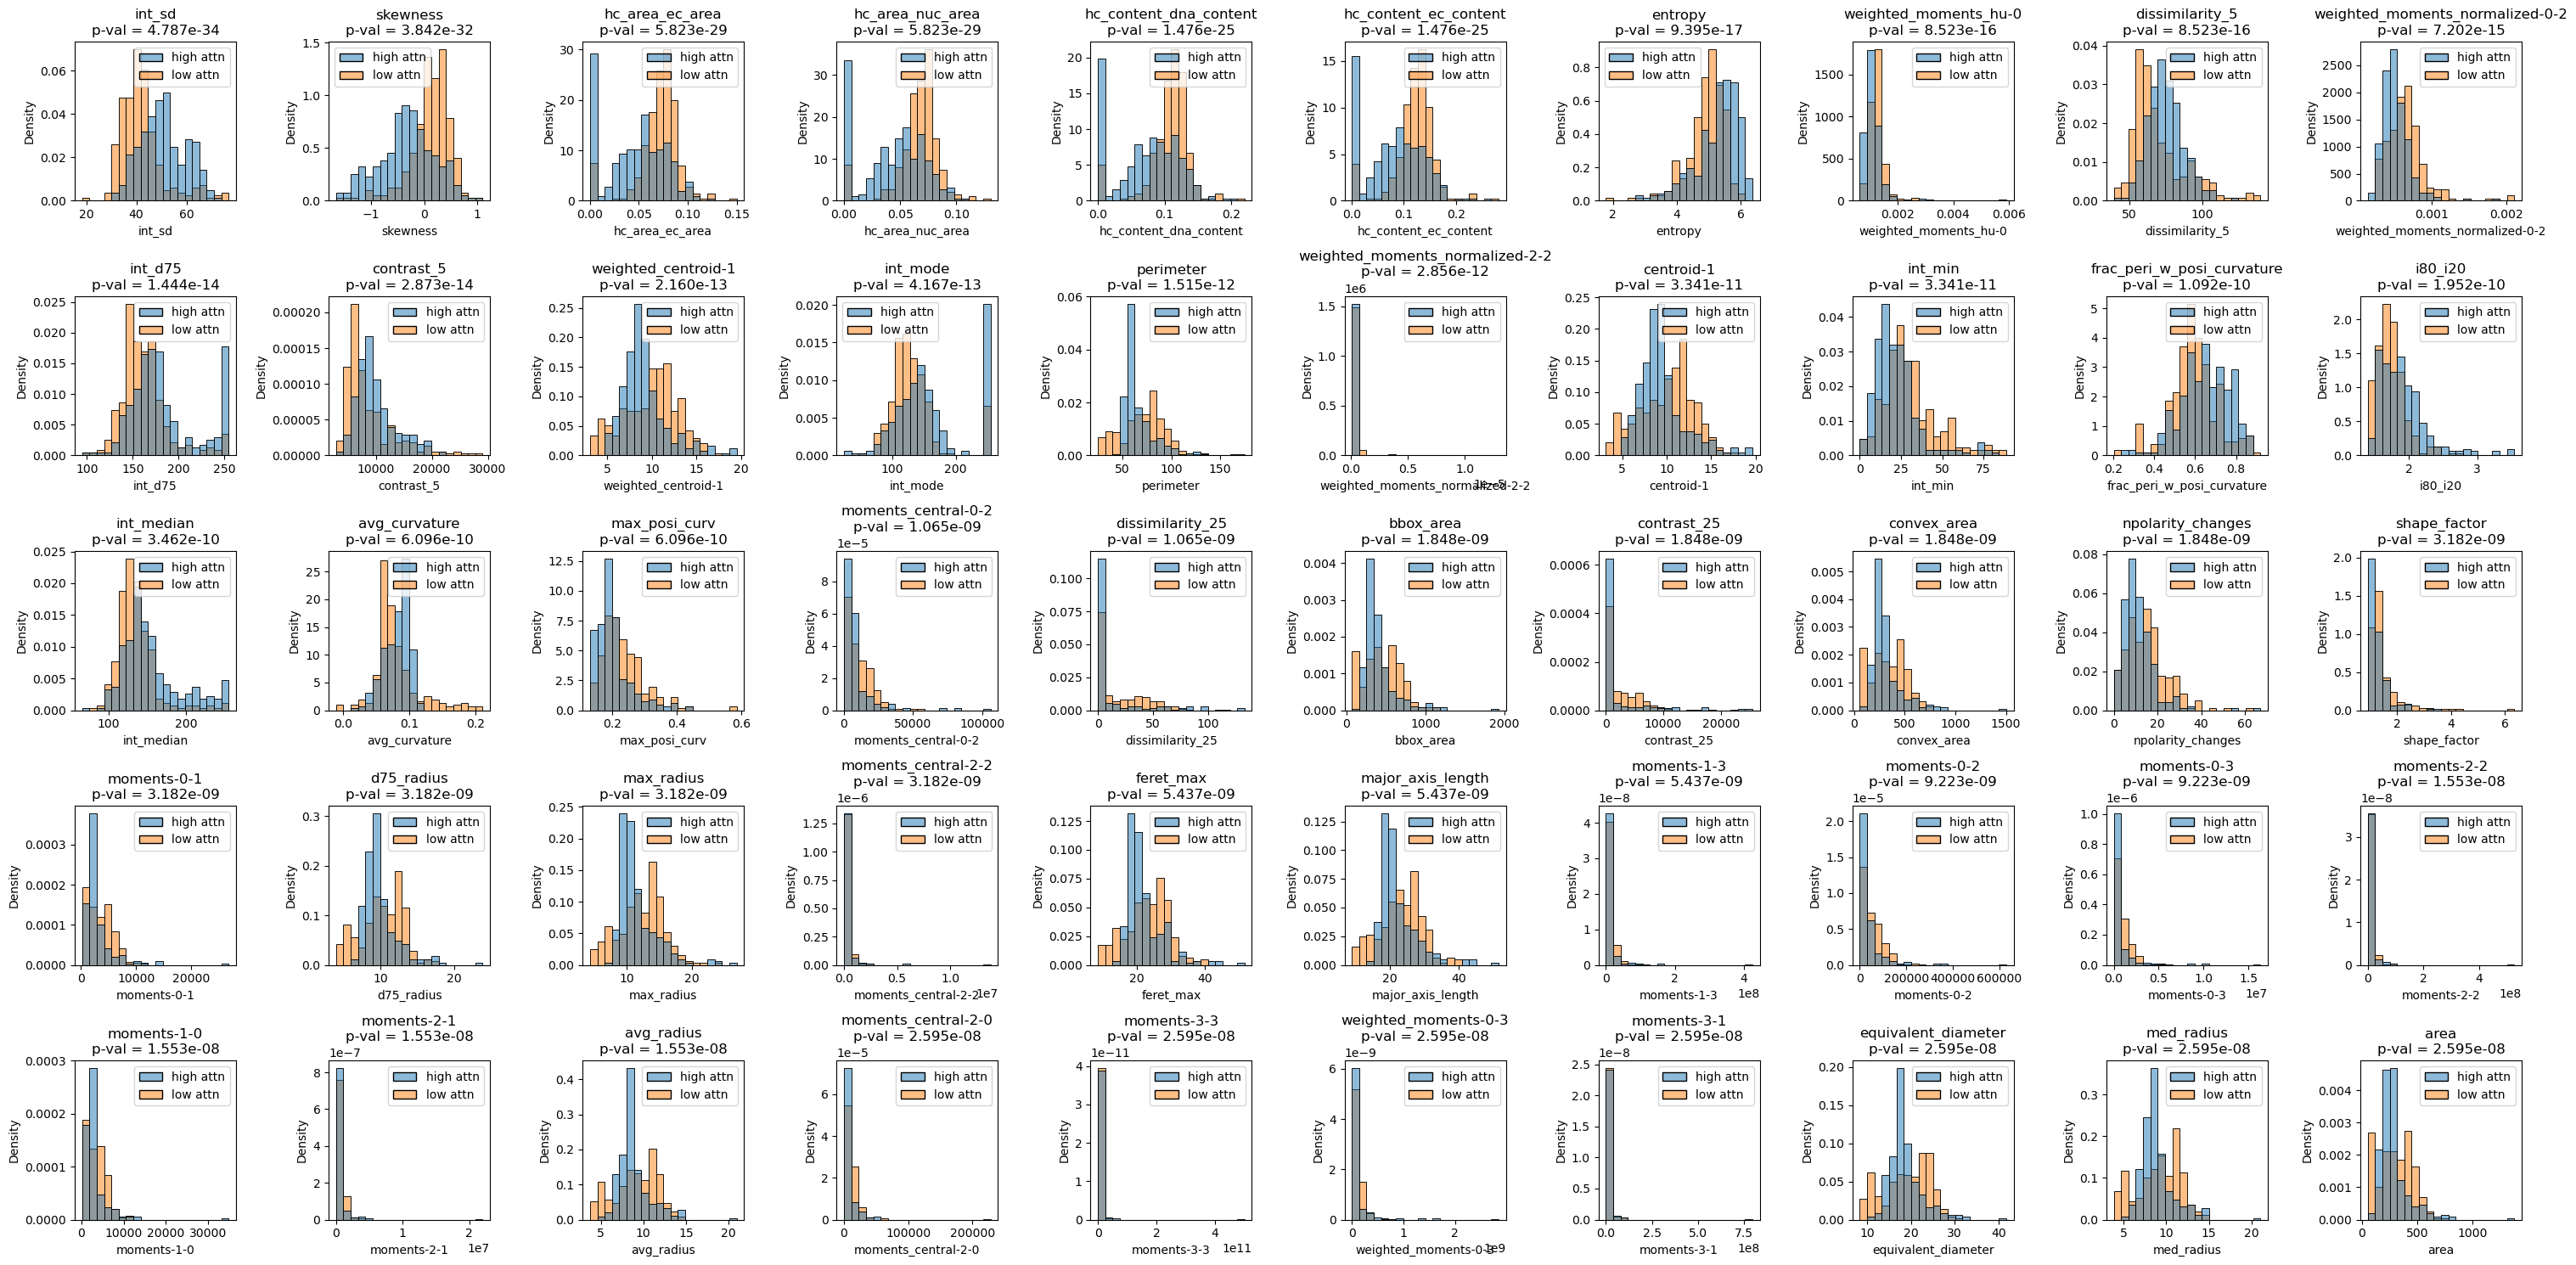

In [107]:
fig, axs = plt.subplots(5, 10, figsize=(30, 15))
for ax, col in zip(axs.flatten(), bot_cnt.sort_values('p-val (low)').index):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_low_idx, bot_low_idx))], x=col, 
                 hue=['high attn'] * len(top_low_idx) + ['low attn'] * len(bot_low_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (low)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

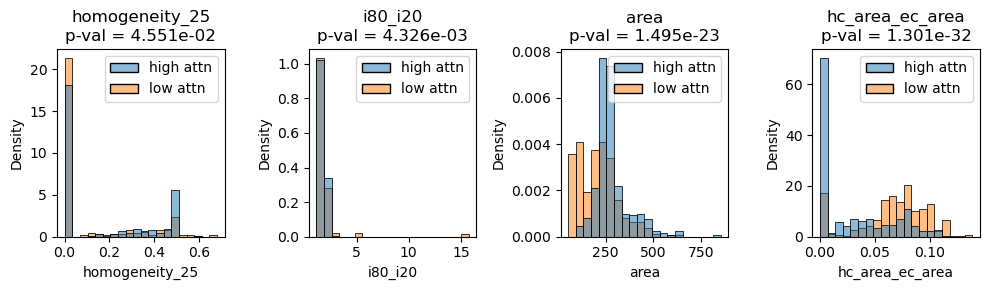

In [108]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for ax, col in zip(axs.flatten(), ['homogeneity_25', 'i80_i20', 'area', 'hc_area_ec_area']):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_up_idx, bot_up_idx))], x=col, 
                 hue=['high attn'] * len(top_up_idx) + ['low attn'] * len(bot_up_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (up)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

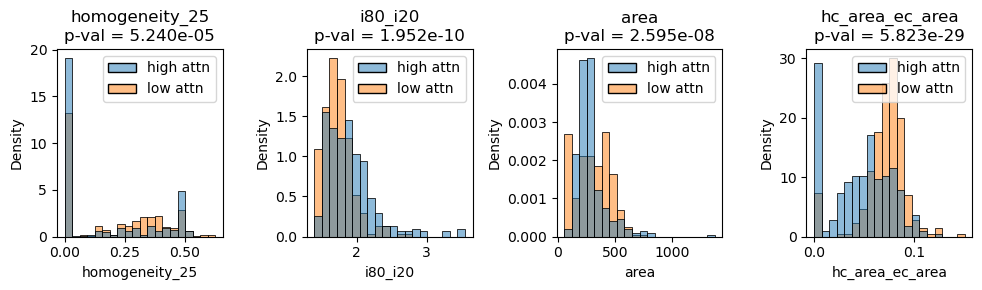

In [109]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for ax, col in zip(axs.flatten(), ['homogeneity_25', 'i80_i20', 'area', 'hc_area_ec_area']):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_low_idx, bot_low_idx))], x=col, 
                 hue=['high attn'] * len(top_low_idx) + ['low attn'] * len(bot_low_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (low)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

## Compare cluster proportions

### Fig. S4c

In [29]:
df = pd.read_csv('results/fig_2_umap_with_clusters.csv', index_col=0)

/tmp/ipykernel_4000902/544513941.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('results/fig_2_umap_with_clusters.csv', index_col=0)


In [30]:
traj = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_trajectory_classes.csv', index_col='patient')
dft = df.merge(traj, on='patient')
dft

plate well  series  cell patient  time    qc       group  diagnosis  \
0           2  A02       0    40    P116     4  True  CNS-Glioma  cancer T1   
1           2  A02       0    89    P116     4  True  CNS-Glioma  cancer T1   
2           2  A02       0    90    P116     4  True  CNS-Glioma  cancer T1   
3           2  A02       0    91    P116     4  True  CNS-Glioma  cancer T1   
4           2  A02       0   106    P116     4  True  CNS-Glioma  cancer T1   
...       ...  ...     ...   ...     ...   ...   ...         ...        ...   
867102     14  H12       9   450     P91     2  True   CNS-other  cancer T1   
867103     14  H12       9   584     P91     2  True   CNS-other  cancer T1   
867104     14  H12       9   601     P91     2  True   CNS-other  cancer T1   
867105     14  H12       9   618     P91     2  True   CNS-other  cancer T1   
867106     14  H12       9   626     P91     2  True   CNS-other  cancer T1   

        plate healthy  umap_x  umap_y  main group cluster trajectory  
0                 NaN     NaN     NaN  CNS-Glioma     NaN         up  
1                 NaN     NaN     NaN  CNS-Glioma     NaN         up  
2                 NaN     NaN     NaN  CNS-Glioma     NaN         up  
3                 NaN     NaN     NaN  CNS-Glioma     NaN         up  
4                 NaN     NaN     NaN  CNS-Glioma     NaN         up  
...               ...     ...     ...         ...     ...        ...  
867102            NaN     NaN     NaN         NaN     NaN         up  
867103            NaN     NaN     NaN         NaN     NaN         up  
867104            NaN     NaN     NaN         NaN     NaN         up  
867105            NaN     NaN     NaN         NaN     NaN         up  
867106            NaN     NaN     NaN         NaN     NaN         up  

[867107 rows x 15 columns]

Text(0.5, 1.0, 'Head & Neck plates only')

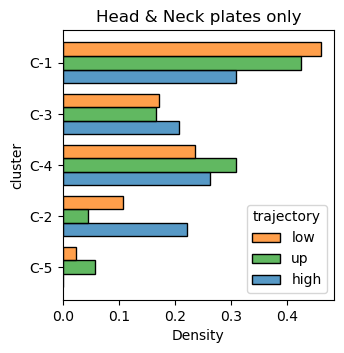

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax = sns.histplot(data=dft[dft['trajectory'].isin(['low', 'up', 'high']) & dft['plate'].astype(int).isin([3, 4, 5, 6])], 
                  y='cluster', hue='trajectory', common_norm=False, palette={'up' : '#2ca02c', 'low' : '#ff7f0e', 'high' : '#1f77b4'},
                  stat='density', discrete=True, multiple='dodge', shrink=.8, hue_order=['low', 'up', 'high'])
sns.move_legend(ax, 'lower right')
ax.set_title('Head & Neck plates only')

## MIL results

In [32]:
pat_diag_groups = pat_info.reset_index().groupby('group')['patient'].unique()
group = 'H&N cancer'
g_pats = p1ts[np.isin(p1ts, pat_diag_groups[group])]
g_pats

array(['P100', 'P107', 'P110', 'P114', 'P120', 'P130', 'P135', 'P14',
       'P142', 'P145', 'P148', 'P149', 'P18', 'P41', 'P55', 'P56', 'P63',
       'P67', 'P72', 'P77', 'P78', 'P79', 'P94', 'P98'], dtype=object)

In [33]:
dfs = []

for p in g_pats:
    name = f'3_6_traj_without_{p}'
    test_loader = test_up_vs_low_bagloader(use_groups=[group], use_patients=[p])
    df, _, _, _ = eval_model(name, test_loader) 
    dfs.append(df)
    print(p, (df['pred'] == df['lab']).mean())


eval_df = pd.concat(dfs)
bag_df = eval_df.groupby(['pat', 'i'])[['pred', 'lab', 'group']].max()
bag_df['correct'] = bag_df['pred'] == bag_df['lab']
agg = bag_df.groupby(['pat', 'group'])['correct'].mean()
print(len(agg))
agg.reset_index()

P100 0.6363636363636364
P107 1.0
P110 0.0
P114 0.9090909090909091
P120 0.0
P130 0.0
P135 0.5454545454545454
P14 1.0
P142 0.0
P145 1.0
P148 0.7272727272727273
P149 0.45454545454545453
P18 0.09090909090909091
P41 1.0
P55 0.5454545454545454
P56 0.6363636363636364
P63 0.0
P67 0.36363636363636365
P72 0.45454545454545453
P77 1.0
P78 1.0
P79 1.0
P94 0.7272727272727273
P98 0.6363636363636364
24


pat group   correct
0   P100    up  0.636364
1   P107   low  1.000000
2   P110   low  0.000000
3   P114    up  0.909091
4   P120    up  0.000000
5   P130    up  0.000000
6   P135    up  0.545455
7    P14   low  1.000000
8   P142    up  0.000000
9   P145   low  1.000000
10  P148   low  0.727273
11  P149   low  0.454545
12   P18   low  0.090909
13   P41    up  1.000000
14   P55   low  0.545455
15   P56    up  0.636364
16   P63   low  0.000000
17   P67    up  0.363636
18   P72   low  0.454545
19   P77    up  1.000000
20   P78    up  1.000000
21   P79    up  1.000000
22   P94    up  0.727273
23   P98    up  0.636364

In [34]:
pat_df = bag_df.groupby(['pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()
pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'low'
pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'up'
pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['low', 'up'])
pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['low', 'up'])
pat_df.set_index(['pat', 'group'])

pred pred_group
pat  group                 
P100 up      1.0         up
P107 low     0.0        low
P110 low     1.0         up
P114 up      1.0         up
P120 up      0.0        low
P130 up      0.0        low
P135 up      1.0         up
P14  low     0.0        low
P142 up      0.0        low
P145 low     0.0        low
P148 low     0.0        low
P149 low     1.0         up
P18  low     1.0         up
P41  up      1.0         up
P55  low     0.0        low
P56  up      1.0         up
P63  low     1.0         up
P67  up      0.0        low
P72  low     1.0         up
P77  up      1.0         up
P78  up      1.0         up
P79  up      1.0         up
P94  up      1.0         up
P98  up      1.0         up

In [35]:
pat_df = pat_df.reset_index()
(pat_df['group'] == pat_df['pred_group']).mean()

0.625

### Fig. 4f

/tmp/ipykernel_4000902/3495692769.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


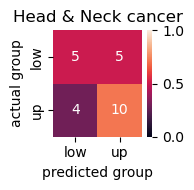

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
mat = pat_df.groupby(
    ['group', 'pred_group'])['pat'].count().reset_index().pivot(index='group', columns='pred_group', values='pat')
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
ax.set_title('Head & Neck cancer')
fig.tight_layout()

In [37]:
from scipy.stats import fisher_exact
res = fisher_exact([[5, 5], [4, 10]], alternative='greater')
res.pvalue

0.26023017902813295

### Fig. S4d

In [38]:
data = PlateDataset([2, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], load_masks=True, strict_discard=False)

  0%|                                                                                                                                                                                          | 0/14 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.84it/s]


In [39]:
traj = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_trajectory_classes.csv', index_col='patient')
groups = pd.read_csv('meta/patient_diagnosis_groups.csv').set_index('patient')

In [40]:
cdf = data.info.groupby(['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H04', 'H05', 'H06', 'H07', 'H09', 'H10', 'H16', 'H18', 'H19',
       'H20', 'H22', 'H23', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32',
       'H33', 'H36', 'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48',
       'H49', 'P100', 'P102', 'P104', 'P105', 'P106', 'P107', 'P109',
       'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P118',
       'P119', 'P12', 'P120', 'P123', 'P124', 'P125', 'P126', 'P127',
       'P128', 'P129', 'P13', 'P130', 'P131', 'P133', 'P134', 'P135',
       'P137', 'P138', 'P14', 'P142', 'P143', 'P144', 'P145', 'P147',
       'P148', 'P149', 'P15', 'P152', 'P154', 'P155', 'P156', 'P157',
       'P158', 'P16', 'P160', 'P161', 'P162', 'P163', 'P164', 'P165',
       'P166', 'P167', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P27', 'P28', 'P29', 'P30', 'P32', 'P33', 'P35',
       'P37', 'P38', 'P39', 'P41', 'P42', 'P43', 'P44', 'P48', 'P50',
       'P52', 'P53', 'P54', 'P55', 'P56', 'P58', 'P59', 'P60', 'P62',
       'P63', 'P6

In [41]:
p1ts = traj[traj['trajectory'].isin(['up', 'low'])].index.values
p1ts = p1ts[np.isin(p1ts, p01s)]
p1ts

array(['P100', 'P104', 'P105', 'P107', 'P110', 'P111', 'P112', 'P113',
       'P114', 'P116', 'P118', 'P120', 'P124', 'P128', 'P13', 'P130',
       'P133', 'P135', 'P138', 'P14', 'P142', 'P143', 'P145', 'P148',
       'P149', 'P15', 'P156', 'P16', 'P162', 'P164', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P25', 'P28', 'P29', 'P30', 'P33', 'P38',
       'P39', 'P41', 'P43', 'P48', 'P52', 'P53', 'P55', 'P56', 'P59',
       'P60', 'P62', 'P63', 'P64', 'P65', 'P67', 'P69', 'P70', 'P72',
       'P73', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P82', 'P83',
       'P84', 'P87', 'P89', 'P90', 'P91', 'P92', 'P94', 'P95', 'P96',
       'P98', 'P99'], dtype=object)

In [45]:
groups['group'].loc['P104']

'CNS-Glioma'

In [46]:
dfs = []

for p in p1ts:
    name = f'2_14_traj_without_{p}'
    test_loader = test_up_vs_low_bagloader(use_patients=[p], use_groups=groups['group'].unique().tolist() + ['other'], 
                                           use_plates=[2, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
    df, _, _, _ = eval_model(name, test_loader) 
    dfs.append(df)
    print(p, (df['pred'] == df['lab']).mean())

eval_df = pd.concat(dfs)
eval_df

P100 1.0
P104 0.0
P105 0.09090909090909091
P107 1.0
P110 0.8181818181818182
P111 0.36363636363636365
P112 0.9090909090909091
P113 0.6363636363636364
P114 0.45454545454545453
P116 0.0
P118 0.5454545454545454
P120 0.36363636363636365
P124 1.0
P128 0.2727272727272727
P13 0.09090909090909091
P130 0.45454545454545453
P133 0.0
P135 1.0
P138 0.18181818181818182
P14 0.9090909090909091
P142 0.0
P143 0.09090909090909091
P145 0.45454545454545453
P148 1.0
P149 1.0
P15 0.18181818181818182
P156 0.6363636363636364
P16 1.0
P162 0.36363636363636365
P164 0.6363636363636364
P18 0.45454545454545453
P19 0.36363636363636365
P20 0.45454545454545453
P21 0.9090909090909091
P22 0.36363636363636365
P23 1.0
P25 0.8181818181818182
P28 0.5454545454545454
P29 1.0
P30 0.7272727272727273
P33 0.2727272727272727
P38 0.2727272727272727
P39 0.7272727272727273
P41 0.9090909090909091
P43 0.2727272727272727
P48 0.9090909090909091
P52 0.6363636363636364
P53 0.8181818181818182
P55 0.45454545454545453
P56 0.18181818181818182
P5

lab  pred   i   pat group  attention 0  attention 1  attention 2  \
0      1   1.0   0  P100    up     0.000638     0.002197     0.000248   
1      1   1.0   0  P100    up     0.000870     0.003027     0.000409   
2      1   1.0   0  P100    up     0.002280     0.005999     0.001572   
3      1   1.0   0  P100    up     0.018267     0.018831     0.021291   
4      1   1.0   0  P100    up     0.000513     0.001807     0.000175   
..   ...   ...  ..   ...   ...          ...          ...          ...   
545    0   0.0  10   P99   low     0.027622     0.015124     0.012573   
546    0   0.0  10   P99   low     0.007639     0.008541     0.005565   
547    0   0.0  10   P99   low     0.028089     0.190277     0.310656   
548    0   0.0  10   P99   low     0.057279     0.018389     0.016850   
549    0   0.0  10   P99   low     0.006129     0.011237     0.007960   

     attention 3  attention 4  raw attention 0  raw attention 1  \
0       0.021199     0.000730        -3.155320        -2.011156   
1       0.020994     0.001019        -2.843987        -1.690671   
2       0.045739     0.002724        -1.880902        -1.006756   
3       0.101396     0.019726         0.199821         0.137201   
4       0.014782     0.000587        -3.372473        -2.206595   
..           ...          ...              ...              ...   
545     0.017348     0.017938         1.325197         0.335429   
546     0.006998     0.003666         0.039886        -0.235980   
547     0.176408     0.001778         1.341978         2.867658   
548     0.019532     0.109788         2.054523         0.530953   
549     0.011050     0.001046        -0.180414         0.038353   

     raw attention 2  raw attention 3  raw attention 4  
0          -3.547586         1.755297        -2.941517  
1          -3.049270         1.745538        -2.608448  
2          -1.701903         2.524274        -1.624994  
3           0.904228         3.320352         0.354824  
4          -3.897770         1.394743        -3.159141  
..               ...              ...              ...  
545         0.511599         0.217940         3.342446  
546        -0.303509        -0.690002         1.754726  
547         3.718695         2.537233         1.030789  
548         0.804379         0.336473         5.154100  
549         0.054429        -0.233134         0.500913  

[44000 rows x 15 columns]

/tmp/ipykernel_4000902/1072466269.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


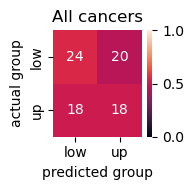

In [62]:
pat_df = bag_df.groupby(['pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).reset_index().rename(columns={'group' : 'trajectory', 'pat' : 'patient'})
pat_df = pat_df.merge(groups.reset_index().rename(columns={'group' : 'diagnosis'}), on='patient', how='left')
pat_df['diagnosis'] = pat_df['diagnosis'].fillna('other')
pat_df.loc[pat_df['pred'] == 0, 'pred_trajectory'] = 'low'
pat_df.loc[pat_df['pred'] == 1, 'pred_trajectory'] = 'up'
pat_df['trajectory'] = pd.Categorical(values=pat_df['trajectory'], categories=['low', 'up'])
pat_df['pred_trajectory'] = pd.Categorical(values=pat_df['pred_trajectory'], categories=['low', 'up'])
pat_df['test correct'] = pat_df['trajectory'] == pat_df['pred_trajectory']
pat_df.set_index(['patient', 'trajectory'])


fig, ax = plt.subplots(1, 1, figsize=(2, 2))
mat = pat_df.groupby(
    ['trajectory', 'pred_trajectory'])['patient'].count().reset_index().pivot(index='trajectory', columns='pred_trajectory', values='patient')
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
ax.set_title('All cancers')
fig.tight_layout()

### Fig. S4e

/tmp/ipykernel_4000902/3831536809.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['diagnosis'] == 'H&N cancer'].groupby(


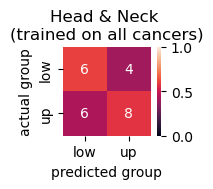

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
mat = pat_df[pat_df['diagnosis'] == 'H&N cancer'].groupby(
    ['trajectory', 'pred_trajectory'])['patient'].count().reset_index().pivot(index='trajectory', columns='pred_trajectory', values='patient')
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
ax.set_title('Head & Neck \n(trained on all cancers)')
fig.tight_layout()

### Fig. S4f

In [66]:
df1 = pd.DataFrame(pat_df.reset_index().groupby(['diagnosis', 'trajectory'])['test correct'].mean() * 100).rename(columns={'test correct': 'test correct %'}).round(decimals=2)
df2 = pd.DataFrame(pat_df.groupby(['diagnosis', 'trajectory'])['patient'].count()).rename(columns={'patient': '# patients'})
df1.merge(df2, left_index=True, right_index=True)

/tmp/ipykernel_4000902/1486983253.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1 = pd.DataFrame(pat_df.reset_index().groupby(['diagnosis', 'trajectory'])['test correct'].mean() * 100).rename(columns={'test correct': 'test correct %'}).round(decimals=2)
/tmp/ipykernel_4000902/1486983253.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = pd.DataFrame(pat_df.groupby(['diagnosis', 'trajectory'])['patient'].count()).rename(columns={'patient': '# patients'})


test correct %  # patients
diagnosis               trajectory                            
CNS-Ependymoma          low                 100.00           4
                        up                   50.00           2
CNS-Glioma              low                  57.14           7
                        up                    0.00           2
CNS-Medulloblastoma     low                 100.00           2
                        up                    0.00           1
CNS-Meningioma          low                  16.67           6
                        up                   20.00           5
CNS-other               low                  50.00           4
                        up                   60.00           5
Chordoma/Chondrosarcoma low                  55.56           9
                        up                   75.00           4
H&N cancer              low                  60.00          10
                        up                   57.14          14
Lymphoma                low                   0.00           2
                        up                     NaN           0
other                   low                    NaN           0
                        up                   66.67           3

## Baseline based on score

In [111]:
good_plates = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [112]:
groups = pd.read_csv('meta/patient_diagnosis_groups.csv').fillna('other')
traj = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_trajectory_classes.csv')
scores = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_scores.csv', index_col=0)
pat_info = traj[traj['trajectory'].isin(['low', 'up'])].merge(groups, on='patient')
pat_info = pat_info.merge(scores[scores['time'] == 1], on='patient')
pat_info = pat_info[pat_info['plate'].isin(good_plates)].set_index('patient')
pat_info

trajectory                    group  time  pred H %  plate     score
patient                                                                     
P100            up               H&N cancer     1  0.083333      3  0.101091
P104           low               CNS-Glioma     1  0.054533      2  0.062223
P105           low           CNS-Meningioma     1  0.186600      7  0.256041
P107           low               H&N cancer     1  0.544940      4  0.695379
P110           low               H&N cancer     1  0.038168      6  0.048322
...            ...                      ...   ...       ...    ...       ...
P94             up               H&N cancer     1  0.063700      6  0.080647
P95             up           CNS-Ependymoma     1  0.073861     12  0.095478
P96             up                CNS-other     1  0.006239     13  0.007810
P98             up               H&N cancer     1  0.033708      6  0.042675
P99            low  Chordoma/Chondrosarcoma     1  0.129091     10  0.143871

[80 rows x 6 columns]

In [113]:
# more than for MIL as some patients have few cells but score was still computed
pats = pat_info[pat_info['group'] == 'H&N cancer'].index.values
len(pats), pats


(24,
 array(['P100', 'P107', 'P110', 'P114', 'P120', 'P130', 'P135', 'P14',
        'P142', 'P145', 'P148', 'P149', 'P18', 'P41', 'P55', 'P56', 'P63',
        'P67', 'P72', 'P77', 'P78', 'P79', 'P94', 'P98'], dtype=object))

0.2741574854748247


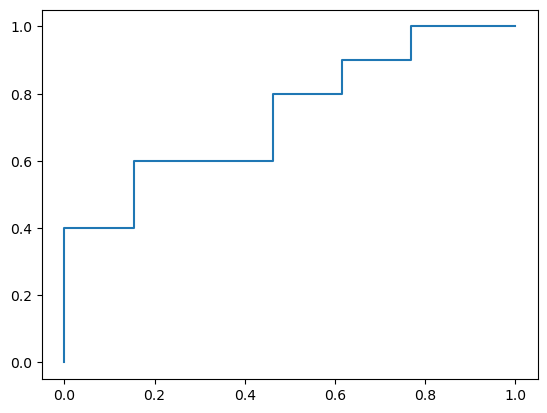

In [114]:
pat = 'P100'
other_pats = pats[pats != pat]
fpr, tpr, thresholds = roc_curve(pat_info.loc[other_pats, 'trajectory'].values == 'low', 
                                 pat_info.loc[other_pats, 'score'].values)
gmeans = np.sqrt(tpr * (1 - fpr))
thresh = thresholds[np.argmax(gmeans)]
scores = pat_info.loc[other_pats, 'score'].sort_values().values
ix = np.argwhere(scores == thresh)[0, 0]
if ix > 0:
  thresh = (scores[ix] + scores[ix - 1]) / 2  # put between class change
print(thresh)
plt.plot(fpr, tpr)

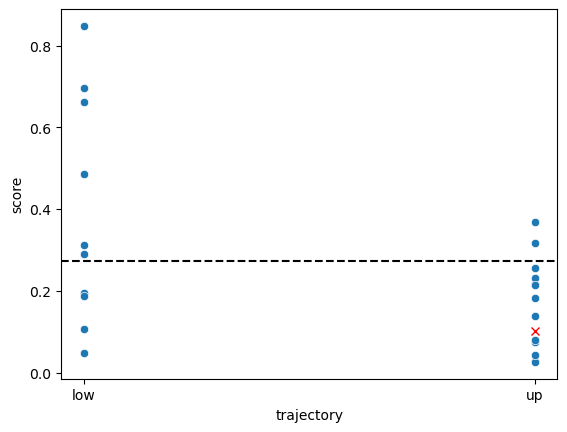

In [115]:
ax = sns.scatterplot(pat_info.loc[other_pats], x='trajectory', y='score')
ax.plot(pat_info.loc[pat, 'trajectory'], pat_info.loc[pat, 'score'], marker='x', color='red')
ax.axhline(thresh, ls='--', color='black')

In [116]:
pat_info.loc[pat, 'score'] >= thresh, pat_info.loc[pat, 'trajectory'] == 'low'

(False, False)

#### Fig. S4g -- Head & Neck

In [117]:
res = []
for pat in pats:
    other_pats = pats[pats != pat]
    fpr, tpr, thresholds = roc_curve(pat_info.loc[other_pats, 'trajectory'].values == 'low', 
                                    pat_info.loc[other_pats, 'score'].values)
    gmeans = np.sqrt(tpr * (1 - fpr))
    thresh = thresholds[np.argmax(gmeans)]
    scores = pat_info.loc[other_pats, 'score'].sort_values().values
    ix = np.argwhere(scores == thresh)[0, 0]
    if ix > 0:
      thresh = (scores[ix] + scores[ix - 1]) / 2  # put between class change
    print(thresh)
    res.append((pat, pat_info.loc[pat, 'trajectory'], 'low' if pat_info.loc[pat, 'score'] >= thresh else 'up'))

pat_df = pd.DataFrame(res, columns=['patient', 'group', 'pred_group'])
pat_df

0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2851415797169992
0.2614695161416035
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247
0.2741574854748247


patient group pred_group
0     P100    up         up
1     P107   low        low
2     P110   low         up
3     P114    up         up
4     P120    up         up
5     P130    up        low
6     P135    up         up
7      P14   low        low
8     P142    up        low
9     P145   low        low
10    P148   low        low
11    P149   low         up
12     P18   low        low
13     P41    up         up
14     P55   low         up
15     P56    up         up
16     P63   low         up
17     P67    up         up
18     P72   low        low
19     P77    up         up
20     P78    up         up
21     P79    up         up
22     P94    up         up
23     P98    up         up

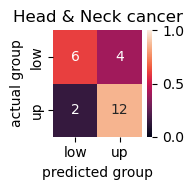

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
mat = pat_df.groupby(
    ['group', 'pred_group'])['patient'].count().reset_index().pivot(index='group', columns='pred_group', values='patient')
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
ax.set_title('Head & Neck cancer')
fig.tight_layout()

### Fig. S4h -- Plates 2-14 (greater/equal thresh for low)

In [119]:
pats = pat_info.index.values
len(pats), pats

(80,
 array(['P100', 'P104', 'P105', 'P107', 'P110', 'P111', 'P112', 'P113',
        'P114', 'P116', 'P118', 'P120', 'P124', 'P128', 'P13', 'P130',
        'P133', 'P135', 'P138', 'P14', 'P142', 'P143', 'P145', 'P148',
        'P149', 'P15', 'P156', 'P16', 'P162', 'P164', 'P18', 'P19', 'P20',
        'P21', 'P22', 'P23', 'P25', 'P28', 'P29', 'P30', 'P33', 'P38',
        'P39', 'P41', 'P43', 'P48', 'P52', 'P53', 'P55', 'P56', 'P59',
        'P60', 'P62', 'P63', 'P64', 'P65', 'P67', 'P69', 'P70', 'P72',
        'P73', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P82', 'P83',
        'P84', 'P87', 'P89', 'P90', 'P91', 'P92', 'P94', 'P95', 'P96',
        'P98', 'P99'], dtype=object))

In [120]:
res = []
for pat in pats:
    other_pats = pats[pats != pat]
    fpr, tpr, thresholds = roc_curve(pat_info.loc[other_pats, 'trajectory'].values == 'low', 
                                    pat_info.loc[other_pats, 'score'].values)
    gmeans = np.sqrt(tpr * (1 - fpr))
    thresh = thresholds[np.argmax(gmeans)]
    scores = pat_info.loc[other_pats, 'score'].sort_values().values
    ix = np.argwhere(scores == thresh)[0, 0]
    if ix > 0:
      thresh = (scores[ix] + scores[ix - 1]) / 2  # put between class change
    print(thresh)
    res.append((pat, pat_info.loc[pat, 'trajectory'], 'low' if pat_info.loc[pat, 'score'] >= thresh else 'up'))

pat_df = pd.DataFrame(res, columns=['patient', 'group', 'pred_group'])
pat_df

0.1698638781221533
0.1698638781221533
0.10347654705954235
0.10347654705954235
0.1698638781221533
0.10347654705954235
0.1698638781221533
0.1698638781221533
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.1698638781221533
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.23485441192042225
0.10347654705954235
0.10347654705954235
0.1698638781221533
0.10347654705954235
0.10347654705954235
0.1698638781221533
0.1698638781221533
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.10347654705954235
0.1698638781221533
0.10347654705954235
0.1698638781221533
0.18472359807483169
0.1698638781221533
0.10347654705954235
0.23485441192042225
0.10347654705954235
0.1698638781221533
0.10347654705954235
0.10347654705954235
0.1698638781221533
0.1698638781221533
0.1698638781221533
0.1698638781221533
0.23485441192042225
0.10347654705954235
0.103476547059542

patient group pred_group
0     P100    up         up
1     P104   low         up
2     P105   low        low
3     P107   low        low
4     P110   low         up
..     ...   ...        ...
75     P94    up         up
76     P95    up         up
77     P96    up         up
78     P98    up         up
79     P99   low         up

[80 rows x 3 columns]

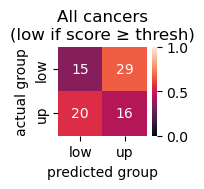

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
mat = pat_df.groupby(
    ['group', 'pred_group'])['patient'].count().reset_index().pivot(index='group', columns='pred_group', values='patient')
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
ax.set_title('All cancers\n(low if score ≥ thresh)')
fig.tight_layout()

### Fig. S4i -- Plates 2-14 (greater/equal thresh for up)

In [122]:
pats = pat_info.index.values
len(pats), pats

(80,
 array(['P100', 'P104', 'P105', 'P107', 'P110', 'P111', 'P112', 'P113',
        'P114', 'P116', 'P118', 'P120', 'P124', 'P128', 'P13', 'P130',
        'P133', 'P135', 'P138', 'P14', 'P142', 'P143', 'P145', 'P148',
        'P149', 'P15', 'P156', 'P16', 'P162', 'P164', 'P18', 'P19', 'P20',
        'P21', 'P22', 'P23', 'P25', 'P28', 'P29', 'P30', 'P33', 'P38',
        'P39', 'P41', 'P43', 'P48', 'P52', 'P53', 'P55', 'P56', 'P59',
        'P60', 'P62', 'P63', 'P64', 'P65', 'P67', 'P69', 'P70', 'P72',
        'P73', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P82', 'P83',
        'P84', 'P87', 'P89', 'P90', 'P91', 'P92', 'P94', 'P95', 'P96',
        'P98', 'P99'], dtype=object))

In [123]:
res = []
for pat in pats:
    other_pats = pats[pats != pat]
    fpr, tpr, thresholds = roc_curve(pat_info.loc[other_pats, 'trajectory'].values == 'up', 
                                    pat_info.loc[other_pats, 'score'].values)
    gmeans = np.sqrt(tpr * (1 - fpr))
    thresh = thresholds[np.argmax(gmeans)]
    scores = pat_info.loc[other_pats, 'score'].sort_values().values
    ix = np.argwhere(scores == thresh)[0, 0]
    if ix > 0:
      thresh = (scores[ix] + scores[ix - 1]) / 2  # put between class change
    print(thresh)
    res.append((pat, pat_info.loc[pat, 'trajectory'], 'up' if pat_info.loc[pat, 'score'] >= thresh else 'low'))

pat_df = pd.DataFrame(res, columns=['patient', 'group', 'pred_group'])
pat_df

0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.06955827380642085
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864
0.07001650023818864


patient group pred_group
0     P100    up         up
1     P104   low        low
2     P105   low         up
3     P107   low         up
4     P110   low        low
..     ...   ...        ...
75     P94    up         up
76     P95    up         up
77     P96    up        low
78     P98    up        low
79     P99   low         up

[80 rows x 3 columns]

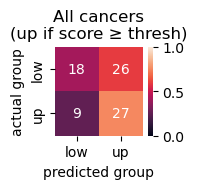

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
mat = pat_df.groupby(
    ['group', 'pred_group'])['patient'].count().reset_index().pivot(index='group', columns='pred_group', values='patient')
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
ax.set_title('All cancers\n(up if score ≥ thresh)')
fig.tight_layout()